# Face Generation
In this project, I will use generative adversarial (GAN) networks to generate new images of faces.
### Get the Data
I'm using two datasets in this project:
- MNIST
- CelebA
- cifar10

Since the celebA dataset is complex, I will be testing my neural network on MNIST before CelebA.  Running the GANs on MNIST will show us how well the model trains sooner.

If you're running this notebook using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [ ]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = './input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist:  12%|█▏        | 7.35K/60.0K [00:18<02:13, 393File/s]

## Explore the Data
### MNIST
The [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

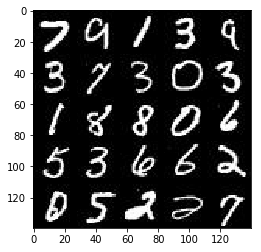

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since we're going to be generating faces, we won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

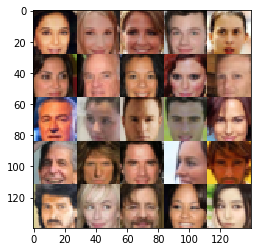

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
Here I will set up the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Here I implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Here I implement the `discriminator` function to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  I am using [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 14x14x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Here I implement the `generator` function to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  I am using [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        
        alpha = 0.2
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x64 now
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Here I implement the `model_loss` function to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  I am using the discriminator and generator functions:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Here I implement the `model_opt` function to create the optimization operations for the GANs. I am using [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Then I filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Here I am using this function show_generator_output to show the current output of the generator during training. It will help us determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Here I implement the `train` function to build and train the GANs.  This is where we will use the model_inputs, model_loss, and model_opt functions already implemented above:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

We will also use the `show_generator_output` to show `generator` output while training. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Need to first map the input_real dims to data_shape
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    ### Build GAN
    
    # Define Model_Inputs
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Define Model_Loss
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # Define Model_Opt
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    ### Training
    n_total_batches = data_shape[0] // batch_size
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            batch_counter = 0
            
            for batch_images in get_batches(batch_size):
                batch_counter += 1
                
                # Need to first scale real image values from [-0.5, 0.5] to [-1, 1]
                batch_images = batch_images*2.0
                
                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                              input_z: batch_z,
                                              lr: learning_rate})
                
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z,
                                                     lr: learning_rate})
                
                # For each 10 batches, get the losses and print them out
                
                if batch_counter % 10 == 0:
                    d_train_loss = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    
                    g_train_loss = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{} - Batch {}/{}: ".format(e+1, epoch_count, batch_counter, n_total_batches),
                         "Discriminator loss = {:.4f} ".format(d_train_loss),
                         "Generator loss = {:.4f}".format(g_train_loss))
                    
                # Show generator output samples so we can see the progress during training
                
                if batch_counter % 100 == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                

### MNIST
Here we can test our GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  We'll want to make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 - Batch 10/1875:  Discriminator loss = 0.6573  Generator loss = 1.4681
Epoch 1/2 - Batch 20/1875:  Discriminator loss = 0.6301  Generator loss = 1.4880
Epoch 1/2 - Batch 30/1875:  Discriminator loss = 5.1544  Generator loss = 0.0133
Epoch 1/2 - Batch 40/1875:  Discriminator loss = 1.7154  Generator loss = 0.4800
Epoch 1/2 - Batch 50/1875:  Discriminator loss = 1.0026  Generator loss = 3.0980
Epoch 1/2 - Batch 60/1875:  Discriminator loss = 0.7684  Generator loss = 1.4531
Epoch 1/2 - Batch 70/1875:  Discriminator loss = 0.6428  Generator loss = 1.8423
Epoch 1/2 - Batch 80/1875:  Discriminator loss = 2.5574  Generator loss = 0.2361
Epoch 1/2 - Batch 90/1875:  Discriminator loss = 1.4586  Generator loss = 0.5461
Epoch 1/2 - Batch 100/1875:  Discriminator loss = 0.8368  Generator loss = 1.5760


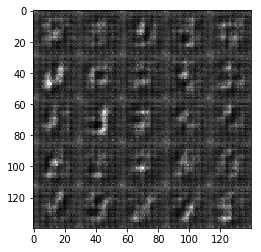

Epoch 1/2 - Batch 110/1875:  Discriminator loss = 0.9137  Generator loss = 1.0284
Epoch 1/2 - Batch 120/1875:  Discriminator loss = 0.6768  Generator loss = 1.6416
Epoch 1/2 - Batch 130/1875:  Discriminator loss = 0.9749  Generator loss = 0.9378
Epoch 1/2 - Batch 140/1875:  Discriminator loss = 2.2054  Generator loss = 4.3492
Epoch 1/2 - Batch 150/1875:  Discriminator loss = 0.8894  Generator loss = 1.0913
Epoch 1/2 - Batch 160/1875:  Discriminator loss = 0.9129  Generator loss = 1.0499
Epoch 1/2 - Batch 170/1875:  Discriminator loss = 0.8517  Generator loss = 1.1487
Epoch 1/2 - Batch 180/1875:  Discriminator loss = 0.7881  Generator loss = 1.7288
Epoch 1/2 - Batch 190/1875:  Discriminator loss = 0.7971  Generator loss = 2.3897
Epoch 1/2 - Batch 200/1875:  Discriminator loss = 0.7759  Generator loss = 1.7526


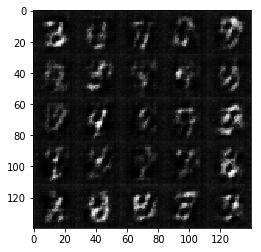

Epoch 1/2 - Batch 210/1875:  Discriminator loss = 0.8303  Generator loss = 1.0704
Epoch 1/2 - Batch 220/1875:  Discriminator loss = 0.8999  Generator loss = 1.0298
Epoch 1/2 - Batch 230/1875:  Discriminator loss = 0.7431  Generator loss = 1.7776
Epoch 1/2 - Batch 240/1875:  Discriminator loss = 0.9090  Generator loss = 0.9690
Epoch 1/2 - Batch 250/1875:  Discriminator loss = 0.9450  Generator loss = 0.8848
Epoch 1/2 - Batch 260/1875:  Discriminator loss = 0.7068  Generator loss = 1.6593
Epoch 1/2 - Batch 270/1875:  Discriminator loss = 0.7077  Generator loss = 2.6723
Epoch 1/2 - Batch 280/1875:  Discriminator loss = 0.6046  Generator loss = 1.7998
Epoch 1/2 - Batch 290/1875:  Discriminator loss = 0.7386  Generator loss = 1.2548
Epoch 1/2 - Batch 300/1875:  Discriminator loss = 0.8476  Generator loss = 1.0780


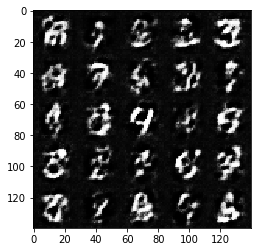

Epoch 1/2 - Batch 310/1875:  Discriminator loss = 0.8099  Generator loss = 1.0881
Epoch 1/2 - Batch 320/1875:  Discriminator loss = 0.8912  Generator loss = 3.0979
Epoch 1/2 - Batch 330/1875:  Discriminator loss = 0.6171  Generator loss = 1.9824
Epoch 1/2 - Batch 340/1875:  Discriminator loss = 0.6341  Generator loss = 1.8937
Epoch 1/2 - Batch 350/1875:  Discriminator loss = 0.5908  Generator loss = 2.2712
Epoch 1/2 - Batch 360/1875:  Discriminator loss = 1.0198  Generator loss = 0.8073
Epoch 1/2 - Batch 370/1875:  Discriminator loss = 0.6837  Generator loss = 1.4304
Epoch 1/2 - Batch 380/1875:  Discriminator loss = 1.3926  Generator loss = 4.5004
Epoch 1/2 - Batch 390/1875:  Discriminator loss = 0.5983  Generator loss = 2.3956
Epoch 1/2 - Batch 400/1875:  Discriminator loss = 0.8485  Generator loss = 1.1041


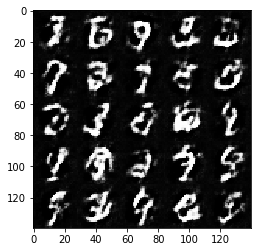

Epoch 1/2 - Batch 410/1875:  Discriminator loss = 0.6946  Generator loss = 1.4126
Epoch 1/2 - Batch 420/1875:  Discriminator loss = 1.0764  Generator loss = 0.7538
Epoch 1/2 - Batch 430/1875:  Discriminator loss = 0.6464  Generator loss = 1.6594
Epoch 1/2 - Batch 440/1875:  Discriminator loss = 0.7135  Generator loss = 1.3833
Epoch 1/2 - Batch 450/1875:  Discriminator loss = 0.6060  Generator loss = 2.1136
Epoch 1/2 - Batch 460/1875:  Discriminator loss = 0.7395  Generator loss = 1.5191
Epoch 1/2 - Batch 470/1875:  Discriminator loss = 0.8440  Generator loss = 1.0331
Epoch 1/2 - Batch 480/1875:  Discriminator loss = 0.6112  Generator loss = 1.9877
Epoch 1/2 - Batch 490/1875:  Discriminator loss = 0.8055  Generator loss = 3.2796
Epoch 1/2 - Batch 500/1875:  Discriminator loss = 0.6215  Generator loss = 1.7516


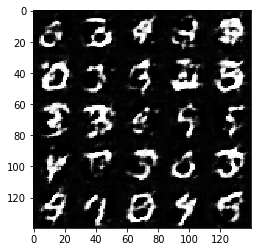

Epoch 1/2 - Batch 510/1875:  Discriminator loss = 0.7081  Generator loss = 3.2487
Epoch 1/2 - Batch 520/1875:  Discriminator loss = 0.6501  Generator loss = 1.6280
Epoch 1/2 - Batch 530/1875:  Discriminator loss = 1.3959  Generator loss = 0.5693
Epoch 1/2 - Batch 540/1875:  Discriminator loss = 1.2293  Generator loss = 3.8614
Epoch 1/2 - Batch 550/1875:  Discriminator loss = 0.7114  Generator loss = 1.6050
Epoch 1/2 - Batch 560/1875:  Discriminator loss = 0.9425  Generator loss = 3.0122
Epoch 1/2 - Batch 570/1875:  Discriminator loss = 0.7519  Generator loss = 1.2770
Epoch 1/2 - Batch 580/1875:  Discriminator loss = 0.5668  Generator loss = 2.2573
Epoch 1/2 - Batch 590/1875:  Discriminator loss = 0.7438  Generator loss = 1.2362
Epoch 1/2 - Batch 600/1875:  Discriminator loss = 2.5245  Generator loss = 0.3385


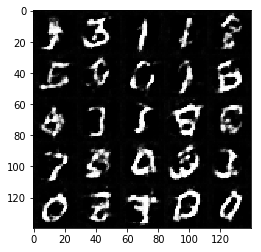

Epoch 1/2 - Batch 610/1875:  Discriminator loss = 0.6606  Generator loss = 2.0546
Epoch 1/2 - Batch 620/1875:  Discriminator loss = 0.8500  Generator loss = 1.9678
Epoch 1/2 - Batch 630/1875:  Discriminator loss = 0.6791  Generator loss = 1.8977
Epoch 1/2 - Batch 640/1875:  Discriminator loss = 0.6091  Generator loss = 1.8910
Epoch 1/2 - Batch 650/1875:  Discriminator loss = 1.1940  Generator loss = 0.6509
Epoch 1/2 - Batch 660/1875:  Discriminator loss = 0.7927  Generator loss = 1.5161
Epoch 1/2 - Batch 670/1875:  Discriminator loss = 0.8046  Generator loss = 1.1357
Epoch 1/2 - Batch 680/1875:  Discriminator loss = 0.7647  Generator loss = 1.2056
Epoch 1/2 - Batch 690/1875:  Discriminator loss = 1.1172  Generator loss = 0.7282
Epoch 1/2 - Batch 700/1875:  Discriminator loss = 0.6202  Generator loss = 2.0327


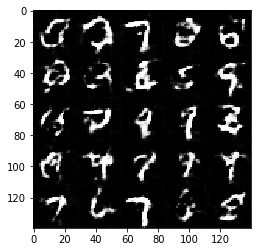

Epoch 1/2 - Batch 710/1875:  Discriminator loss = 0.7173  Generator loss = 1.5636
Epoch 1/2 - Batch 720/1875:  Discriminator loss = 0.9518  Generator loss = 0.8653
Epoch 1/2 - Batch 730/1875:  Discriminator loss = 1.0920  Generator loss = 3.1176
Epoch 1/2 - Batch 740/1875:  Discriminator loss = 1.4703  Generator loss = 0.5433
Epoch 1/2 - Batch 750/1875:  Discriminator loss = 0.6856  Generator loss = 1.7533
Epoch 1/2 - Batch 760/1875:  Discriminator loss = 0.7781  Generator loss = 1.2498
Epoch 1/2 - Batch 770/1875:  Discriminator loss = 0.6761  Generator loss = 1.6325
Epoch 1/2 - Batch 780/1875:  Discriminator loss = 0.8875  Generator loss = 0.9442
Epoch 1/2 - Batch 790/1875:  Discriminator loss = 0.7644  Generator loss = 1.3131
Epoch 1/2 - Batch 800/1875:  Discriminator loss = 1.1297  Generator loss = 2.8615


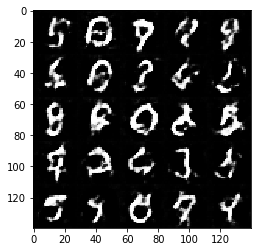

Epoch 1/2 - Batch 810/1875:  Discriminator loss = 0.6699  Generator loss = 1.5156
Epoch 1/2 - Batch 820/1875:  Discriminator loss = 0.6529  Generator loss = 1.7118
Epoch 1/2 - Batch 830/1875:  Discriminator loss = 1.5427  Generator loss = 0.5094
Epoch 1/2 - Batch 840/1875:  Discriminator loss = 0.9715  Generator loss = 0.9464
Epoch 1/2 - Batch 850/1875:  Discriminator loss = 0.7208  Generator loss = 1.4120
Epoch 1/2 - Batch 860/1875:  Discriminator loss = 0.8015  Generator loss = 1.3083
Epoch 1/2 - Batch 870/1875:  Discriminator loss = 0.6583  Generator loss = 1.4820
Epoch 1/2 - Batch 880/1875:  Discriminator loss = 0.6707  Generator loss = 1.5812
Epoch 1/2 - Batch 890/1875:  Discriminator loss = 1.0444  Generator loss = 0.9250
Epoch 1/2 - Batch 900/1875:  Discriminator loss = 1.4003  Generator loss = 0.5315


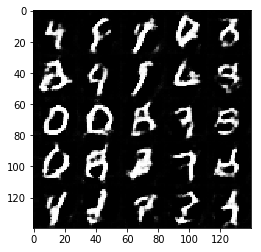

Epoch 1/2 - Batch 910/1875:  Discriminator loss = 1.2957  Generator loss = 0.5968
Epoch 1/2 - Batch 920/1875:  Discriminator loss = 0.7527  Generator loss = 1.4413
Epoch 1/2 - Batch 930/1875:  Discriminator loss = 0.9978  Generator loss = 0.8818
Epoch 1/2 - Batch 940/1875:  Discriminator loss = 0.8753  Generator loss = 1.0301
Epoch 1/2 - Batch 950/1875:  Discriminator loss = 2.1760  Generator loss = 0.2281
Epoch 1/2 - Batch 960/1875:  Discriminator loss = 0.6789  Generator loss = 1.4804
Epoch 1/2 - Batch 970/1875:  Discriminator loss = 0.9068  Generator loss = 0.9318
Epoch 1/2 - Batch 980/1875:  Discriminator loss = 0.8160  Generator loss = 1.3262
Epoch 1/2 - Batch 990/1875:  Discriminator loss = 0.9808  Generator loss = 0.8615
Epoch 1/2 - Batch 1000/1875:  Discriminator loss = 0.7746  Generator loss = 1.2132


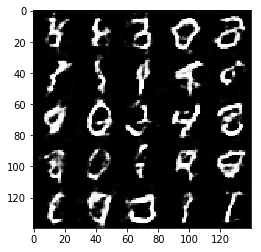

Epoch 1/2 - Batch 1010/1875:  Discriminator loss = 0.7891  Generator loss = 1.1619
Epoch 1/2 - Batch 1020/1875:  Discriminator loss = 1.0402  Generator loss = 0.8012
Epoch 1/2 - Batch 1030/1875:  Discriminator loss = 1.6435  Generator loss = 0.4592
Epoch 1/2 - Batch 1040/1875:  Discriminator loss = 0.7301  Generator loss = 1.6474
Epoch 1/2 - Batch 1050/1875:  Discriminator loss = 0.7478  Generator loss = 1.4466
Epoch 1/2 - Batch 1060/1875:  Discriminator loss = 0.7334  Generator loss = 1.3512
Epoch 1/2 - Batch 1070/1875:  Discriminator loss = 0.8082  Generator loss = 1.1373
Epoch 1/2 - Batch 1080/1875:  Discriminator loss = 0.9328  Generator loss = 0.8743
Epoch 1/2 - Batch 1090/1875:  Discriminator loss = 1.4069  Generator loss = 0.5242
Epoch 1/2 - Batch 1100/1875:  Discriminator loss = 1.4020  Generator loss = 0.5204


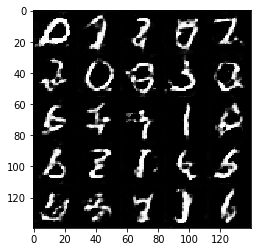

Epoch 1/2 - Batch 1110/1875:  Discriminator loss = 1.3845  Generator loss = 2.9935
Epoch 1/2 - Batch 1120/1875:  Discriminator loss = 1.1931  Generator loss = 0.6370
Epoch 1/2 - Batch 1130/1875:  Discriminator loss = 1.2520  Generator loss = 0.6906
Epoch 1/2 - Batch 1140/1875:  Discriminator loss = 0.8150  Generator loss = 1.2361
Epoch 1/2 - Batch 1150/1875:  Discriminator loss = 0.5861  Generator loss = 1.8908
Epoch 1/2 - Batch 1160/1875:  Discriminator loss = 1.0596  Generator loss = 0.7798
Epoch 1/2 - Batch 1170/1875:  Discriminator loss = 0.7340  Generator loss = 1.4874
Epoch 1/2 - Batch 1180/1875:  Discriminator loss = 0.7775  Generator loss = 1.3069
Epoch 1/2 - Batch 1190/1875:  Discriminator loss = 0.7807  Generator loss = 1.2398
Epoch 1/2 - Batch 1200/1875:  Discriminator loss = 0.8449  Generator loss = 1.0848


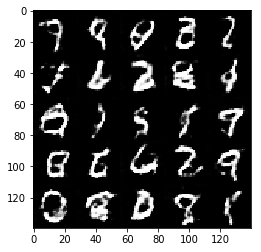

Epoch 1/2 - Batch 1210/1875:  Discriminator loss = 0.6481  Generator loss = 1.8292
Epoch 1/2 - Batch 1220/1875:  Discriminator loss = 2.2497  Generator loss = 0.2728
Epoch 1/2 - Batch 1230/1875:  Discriminator loss = 0.8380  Generator loss = 1.2255
Epoch 1/2 - Batch 1240/1875:  Discriminator loss = 0.8541  Generator loss = 1.0895
Epoch 1/2 - Batch 1250/1875:  Discriminator loss = 0.7179  Generator loss = 1.3668
Epoch 1/2 - Batch 1260/1875:  Discriminator loss = 0.9823  Generator loss = 0.8911
Epoch 1/2 - Batch 1270/1875:  Discriminator loss = 0.5771  Generator loss = 1.7703
Epoch 1/2 - Batch 1280/1875:  Discriminator loss = 3.7216  Generator loss = 6.1754
Epoch 1/2 - Batch 1290/1875:  Discriminator loss = 0.7941  Generator loss = 1.2012
Epoch 1/2 - Batch 1300/1875:  Discriminator loss = 0.8941  Generator loss = 1.1668


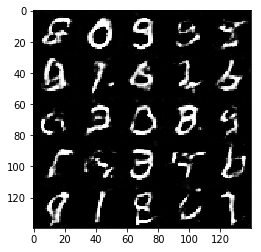

Epoch 1/2 - Batch 1310/1875:  Discriminator loss = 0.9704  Generator loss = 0.8949
Epoch 1/2 - Batch 1320/1875:  Discriminator loss = 0.6994  Generator loss = 1.5140
Epoch 1/2 - Batch 1330/1875:  Discriminator loss = 0.8541  Generator loss = 1.0703
Epoch 1/2 - Batch 1340/1875:  Discriminator loss = 1.0206  Generator loss = 0.7929
Epoch 1/2 - Batch 1350/1875:  Discriminator loss = 1.3302  Generator loss = 0.5620
Epoch 1/2 - Batch 1360/1875:  Discriminator loss = 1.0632  Generator loss = 0.7564
Epoch 1/2 - Batch 1370/1875:  Discriminator loss = 0.7530  Generator loss = 1.3200
Epoch 1/2 - Batch 1380/1875:  Discriminator loss = 0.6457  Generator loss = 1.6366
Epoch 1/2 - Batch 1390/1875:  Discriminator loss = 0.8566  Generator loss = 1.0855
Epoch 1/2 - Batch 1400/1875:  Discriminator loss = 0.7755  Generator loss = 1.2631


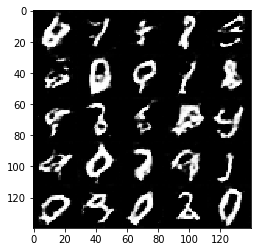

Epoch 1/2 - Batch 1410/1875:  Discriminator loss = 0.6481  Generator loss = 1.5821
Epoch 1/2 - Batch 1420/1875:  Discriminator loss = 0.6825  Generator loss = 1.5516
Epoch 1/2 - Batch 1430/1875:  Discriminator loss = 1.2824  Generator loss = 3.1117
Epoch 1/2 - Batch 1440/1875:  Discriminator loss = 0.7362  Generator loss = 1.5108
Epoch 1/2 - Batch 1450/1875:  Discriminator loss = 0.6954  Generator loss = 1.4694
Epoch 1/2 - Batch 1460/1875:  Discriminator loss = 0.8609  Generator loss = 1.9418
Epoch 1/2 - Batch 1470/1875:  Discriminator loss = 0.6756  Generator loss = 1.4489
Epoch 1/2 - Batch 1480/1875:  Discriminator loss = 0.8906  Generator loss = 0.9960
Epoch 1/2 - Batch 1490/1875:  Discriminator loss = 0.9300  Generator loss = 0.9580
Epoch 1/2 - Batch 1500/1875:  Discriminator loss = 0.6550  Generator loss = 1.5760


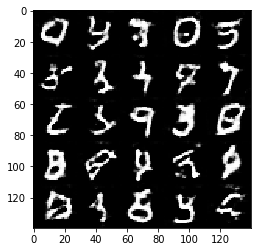

Epoch 1/2 - Batch 1510/1875:  Discriminator loss = 0.8878  Generator loss = 1.0408
Epoch 1/2 - Batch 1520/1875:  Discriminator loss = 0.7569  Generator loss = 1.3211
Epoch 1/2 - Batch 1530/1875:  Discriminator loss = 0.8161  Generator loss = 1.8723
Epoch 1/2 - Batch 1540/1875:  Discriminator loss = 0.6677  Generator loss = 1.6607
Epoch 1/2 - Batch 1550/1875:  Discriminator loss = 0.8296  Generator loss = 1.1218
Epoch 1/2 - Batch 1560/1875:  Discriminator loss = 2.8851  Generator loss = 0.1509
Epoch 1/2 - Batch 1570/1875:  Discriminator loss = 1.0673  Generator loss = 2.4730
Epoch 1/2 - Batch 1580/1875:  Discriminator loss = 1.1733  Generator loss = 3.2225
Epoch 1/2 - Batch 1590/1875:  Discriminator loss = 0.8282  Generator loss = 1.3944
Epoch 1/2 - Batch 1600/1875:  Discriminator loss = 1.1270  Generator loss = 3.3463


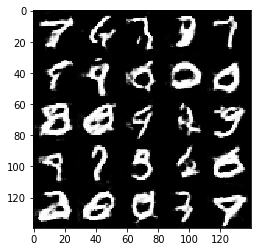

Epoch 1/2 - Batch 1610/1875:  Discriminator loss = 0.7461  Generator loss = 2.0168
Epoch 1/2 - Batch 1620/1875:  Discriminator loss = 0.7401  Generator loss = 1.2711
Epoch 1/2 - Batch 1630/1875:  Discriminator loss = 0.6357  Generator loss = 1.6309
Epoch 1/2 - Batch 1640/1875:  Discriminator loss = 0.8170  Generator loss = 1.1434
Epoch 1/2 - Batch 1650/1875:  Discriminator loss = 1.0926  Generator loss = 0.9327
Epoch 1/2 - Batch 1660/1875:  Discriminator loss = 0.8698  Generator loss = 1.5036
Epoch 1/2 - Batch 1670/1875:  Discriminator loss = 1.3721  Generator loss = 0.5605
Epoch 1/2 - Batch 1680/1875:  Discriminator loss = 0.7919  Generator loss = 1.8703
Epoch 1/2 - Batch 1690/1875:  Discriminator loss = 0.8681  Generator loss = 1.5174
Epoch 1/2 - Batch 1700/1875:  Discriminator loss = 0.8603  Generator loss = 1.0899


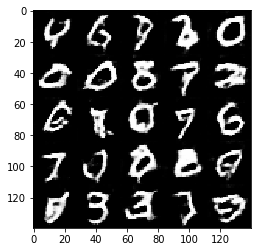

Epoch 1/2 - Batch 1710/1875:  Discriminator loss = 0.7588  Generator loss = 1.2707
Epoch 1/2 - Batch 1720/1875:  Discriminator loss = 0.7485  Generator loss = 1.3022
Epoch 1/2 - Batch 1730/1875:  Discriminator loss = 0.6071  Generator loss = 1.6984
Epoch 1/2 - Batch 1740/1875:  Discriminator loss = 1.0756  Generator loss = 0.8486
Epoch 1/2 - Batch 1750/1875:  Discriminator loss = 0.7626  Generator loss = 1.2455
Epoch 1/2 - Batch 1760/1875:  Discriminator loss = 0.9194  Generator loss = 1.3097
Epoch 1/2 - Batch 1770/1875:  Discriminator loss = 0.8365  Generator loss = 2.1953
Epoch 1/2 - Batch 1780/1875:  Discriminator loss = 0.7467  Generator loss = 1.3496
Epoch 1/2 - Batch 1790/1875:  Discriminator loss = 0.7488  Generator loss = 1.3058
Epoch 1/2 - Batch 1800/1875:  Discriminator loss = 0.8779  Generator loss = 2.3218


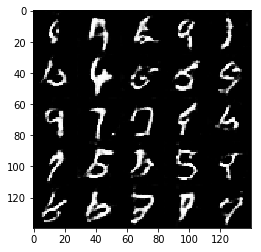

Epoch 1/2 - Batch 1810/1875:  Discriminator loss = 0.7512  Generator loss = 1.7013
Epoch 1/2 - Batch 1820/1875:  Discriminator loss = 1.3592  Generator loss = 0.5270
Epoch 1/2 - Batch 1830/1875:  Discriminator loss = 1.0212  Generator loss = 0.8981
Epoch 1/2 - Batch 1840/1875:  Discriminator loss = 0.7072  Generator loss = 1.4307
Epoch 1/2 - Batch 1850/1875:  Discriminator loss = 0.9450  Generator loss = 0.9626
Epoch 1/2 - Batch 1860/1875:  Discriminator loss = 0.6279  Generator loss = 2.0790
Epoch 1/2 - Batch 1870/1875:  Discriminator loss = 0.7228  Generator loss = 1.9149
Epoch 2/2 - Batch 10/1875:  Discriminator loss = 0.7032  Generator loss = 1.5401
Epoch 2/2 - Batch 20/1875:  Discriminator loss = 0.6014  Generator loss = 1.7287
Epoch 2/2 - Batch 30/1875:  Discriminator loss = 0.7665  Generator loss = 1.3036
Epoch 2/2 - Batch 40/1875:  Discriminator loss = 0.9341  Generator loss = 0.9258
Epoch 2/2 - Batch 50/1875:  Discriminator loss = 1.7118  Generator loss = 0.4294
Epoch 2/2 - Ba

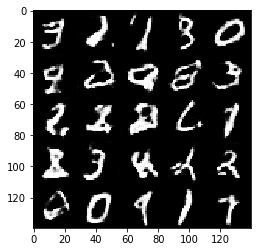

Epoch 2/2 - Batch 110/1875:  Discriminator loss = 1.0043  Generator loss = 0.8894
Epoch 2/2 - Batch 120/1875:  Discriminator loss = 0.9445  Generator loss = 1.0847
Epoch 2/2 - Batch 130/1875:  Discriminator loss = 1.6671  Generator loss = 0.4790
Epoch 2/2 - Batch 140/1875:  Discriminator loss = 1.2943  Generator loss = 2.5314
Epoch 2/2 - Batch 150/1875:  Discriminator loss = 0.7133  Generator loss = 1.4842
Epoch 2/2 - Batch 160/1875:  Discriminator loss = 0.6094  Generator loss = 1.7733
Epoch 2/2 - Batch 170/1875:  Discriminator loss = 1.2008  Generator loss = 0.6834
Epoch 2/2 - Batch 180/1875:  Discriminator loss = 0.8309  Generator loss = 1.2453
Epoch 2/2 - Batch 190/1875:  Discriminator loss = 0.6017  Generator loss = 2.6405
Epoch 2/2 - Batch 200/1875:  Discriminator loss = 0.7710  Generator loss = 1.2492


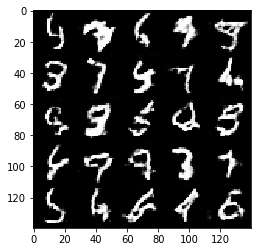

Epoch 2/2 - Batch 210/1875:  Discriminator loss = 0.7852  Generator loss = 1.7171
Epoch 2/2 - Batch 220/1875:  Discriminator loss = 0.6197  Generator loss = 2.1713
Epoch 2/2 - Batch 230/1875:  Discriminator loss = 0.6711  Generator loss = 1.6404
Epoch 2/2 - Batch 240/1875:  Discriminator loss = 0.8612  Generator loss = 1.0382
Epoch 2/2 - Batch 250/1875:  Discriminator loss = 0.6610  Generator loss = 1.7400
Epoch 2/2 - Batch 260/1875:  Discriminator loss = 0.9667  Generator loss = 0.8603
Epoch 2/2 - Batch 270/1875:  Discriminator loss = 3.0034  Generator loss = 5.7176
Epoch 2/2 - Batch 280/1875:  Discriminator loss = 0.6609  Generator loss = 1.9693
Epoch 2/2 - Batch 290/1875:  Discriminator loss = 0.8370  Generator loss = 1.7711
Epoch 2/2 - Batch 300/1875:  Discriminator loss = 0.6772  Generator loss = 1.6175


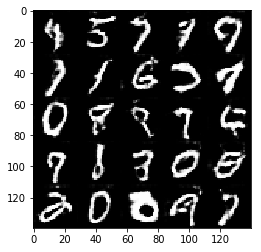

Epoch 2/2 - Batch 310/1875:  Discriminator loss = 1.1146  Generator loss = 0.8246
Epoch 2/2 - Batch 320/1875:  Discriminator loss = 1.1394  Generator loss = 0.8304
Epoch 2/2 - Batch 330/1875:  Discriminator loss = 1.2823  Generator loss = 0.6235
Epoch 2/2 - Batch 340/1875:  Discriminator loss = 0.6860  Generator loss = 1.5559
Epoch 2/2 - Batch 350/1875:  Discriminator loss = 0.8821  Generator loss = 2.2819
Epoch 2/2 - Batch 360/1875:  Discriminator loss = 0.7909  Generator loss = 1.5008
Epoch 2/2 - Batch 370/1875:  Discriminator loss = 0.9149  Generator loss = 2.6521
Epoch 2/2 - Batch 380/1875:  Discriminator loss = 0.6769  Generator loss = 1.4615
Epoch 2/2 - Batch 390/1875:  Discriminator loss = 0.7143  Generator loss = 1.5758
Epoch 2/2 - Batch 400/1875:  Discriminator loss = 1.1303  Generator loss = 0.7195


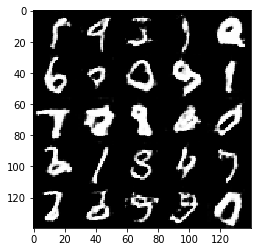

Epoch 2/2 - Batch 410/1875:  Discriminator loss = 0.8557  Generator loss = 1.2921
Epoch 2/2 - Batch 420/1875:  Discriminator loss = 1.4397  Generator loss = 0.5110
Epoch 2/2 - Batch 430/1875:  Discriminator loss = 0.7641  Generator loss = 1.5419
Epoch 2/2 - Batch 440/1875:  Discriminator loss = 0.6947  Generator loss = 1.5092
Epoch 2/2 - Batch 450/1875:  Discriminator loss = 0.8160  Generator loss = 1.1394
Epoch 2/2 - Batch 460/1875:  Discriminator loss = 0.9372  Generator loss = 0.9327
Epoch 2/2 - Batch 470/1875:  Discriminator loss = 2.0991  Generator loss = 0.2609
Epoch 2/2 - Batch 480/1875:  Discriminator loss = 0.9719  Generator loss = 0.9051
Epoch 2/2 - Batch 490/1875:  Discriminator loss = 0.7810  Generator loss = 1.2128
Epoch 2/2 - Batch 500/1875:  Discriminator loss = 1.0101  Generator loss = 0.8959


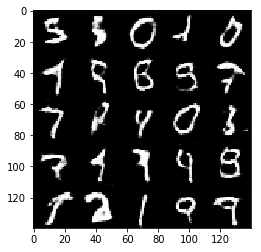

Epoch 2/2 - Batch 510/1875:  Discriminator loss = 0.6983  Generator loss = 1.6288
Epoch 2/2 - Batch 520/1875:  Discriminator loss = 0.8481  Generator loss = 1.1431
Epoch 2/2 - Batch 530/1875:  Discriminator loss = 0.7954  Generator loss = 1.1667
Epoch 2/2 - Batch 540/1875:  Discriminator loss = 0.9616  Generator loss = 0.9569
Epoch 2/2 - Batch 550/1875:  Discriminator loss = 0.9200  Generator loss = 0.9864
Epoch 2/2 - Batch 560/1875:  Discriminator loss = 0.6749  Generator loss = 1.8427
Epoch 2/2 - Batch 570/1875:  Discriminator loss = 1.0969  Generator loss = 1.1667
Epoch 2/2 - Batch 580/1875:  Discriminator loss = 0.6931  Generator loss = 1.4962
Epoch 2/2 - Batch 590/1875:  Discriminator loss = 0.7032  Generator loss = 1.5966
Epoch 2/2 - Batch 600/1875:  Discriminator loss = 0.7273  Generator loss = 1.3331


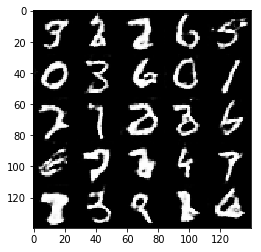

Epoch 2/2 - Batch 610/1875:  Discriminator loss = 3.4878  Generator loss = 0.1119
Epoch 2/2 - Batch 620/1875:  Discriminator loss = 0.8267  Generator loss = 1.2363
Epoch 2/2 - Batch 630/1875:  Discriminator loss = 0.6830  Generator loss = 1.5847
Epoch 2/2 - Batch 640/1875:  Discriminator loss = 0.7100  Generator loss = 1.8171
Epoch 2/2 - Batch 650/1875:  Discriminator loss = 0.8650  Generator loss = 1.0548
Epoch 2/2 - Batch 660/1875:  Discriminator loss = 0.7270  Generator loss = 1.3445
Epoch 2/2 - Batch 670/1875:  Discriminator loss = 0.6353  Generator loss = 1.6968
Epoch 2/2 - Batch 680/1875:  Discriminator loss = 0.7262  Generator loss = 1.4420
Epoch 2/2 - Batch 690/1875:  Discriminator loss = 0.8755  Generator loss = 0.9864
Epoch 2/2 - Batch 700/1875:  Discriminator loss = 0.7808  Generator loss = 1.3933


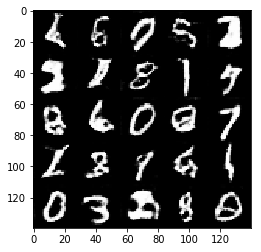

Epoch 2/2 - Batch 710/1875:  Discriminator loss = 1.7825  Generator loss = 3.7647
Epoch 2/2 - Batch 720/1875:  Discriminator loss = 1.3405  Generator loss = 0.6189
Epoch 2/2 - Batch 730/1875:  Discriminator loss = 0.7142  Generator loss = 1.3392
Epoch 2/2 - Batch 740/1875:  Discriminator loss = 0.7738  Generator loss = 1.2650
Epoch 2/2 - Batch 750/1875:  Discriminator loss = 0.5917  Generator loss = 1.7624
Epoch 2/2 - Batch 760/1875:  Discriminator loss = 0.7574  Generator loss = 1.3253
Epoch 2/2 - Batch 770/1875:  Discriminator loss = 0.6489  Generator loss = 1.5359
Epoch 2/2 - Batch 780/1875:  Discriminator loss = 1.8200  Generator loss = 0.3838
Epoch 2/2 - Batch 790/1875:  Discriminator loss = 0.6468  Generator loss = 1.7346
Epoch 2/2 - Batch 800/1875:  Discriminator loss = 0.7021  Generator loss = 1.8346


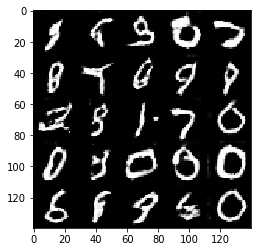

Epoch 2/2 - Batch 810/1875:  Discriminator loss = 1.0007  Generator loss = 0.9792
Epoch 2/2 - Batch 820/1875:  Discriminator loss = 0.6192  Generator loss = 1.7688
Epoch 2/2 - Batch 830/1875:  Discriminator loss = 0.7028  Generator loss = 1.3930
Epoch 2/2 - Batch 840/1875:  Discriminator loss = 0.6074  Generator loss = 2.5998
Epoch 2/2 - Batch 850/1875:  Discriminator loss = 0.6781  Generator loss = 1.6219
Epoch 2/2 - Batch 860/1875:  Discriminator loss = 0.8358  Generator loss = 0.9950
Epoch 2/2 - Batch 870/1875:  Discriminator loss = 0.6366  Generator loss = 1.5401
Epoch 2/2 - Batch 880/1875:  Discriminator loss = 0.5614  Generator loss = 1.8543
Epoch 2/2 - Batch 890/1875:  Discriminator loss = 0.6513  Generator loss = 1.6267
Epoch 2/2 - Batch 900/1875:  Discriminator loss = 0.6386  Generator loss = 1.5601


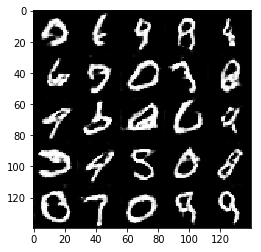

Epoch 2/2 - Batch 910/1875:  Discriminator loss = 0.7415  Generator loss = 1.3265
Epoch 2/2 - Batch 920/1875:  Discriminator loss = 0.5369  Generator loss = 2.0704
Epoch 2/2 - Batch 930/1875:  Discriminator loss = 0.6584  Generator loss = 2.2529
Epoch 2/2 - Batch 940/1875:  Discriminator loss = 0.9195  Generator loss = 1.1603
Epoch 2/2 - Batch 950/1875:  Discriminator loss = 1.4260  Generator loss = 0.5413
Epoch 2/2 - Batch 960/1875:  Discriminator loss = 0.6049  Generator loss = 2.3905
Epoch 2/2 - Batch 970/1875:  Discriminator loss = 0.9160  Generator loss = 1.0783
Epoch 2/2 - Batch 980/1875:  Discriminator loss = 0.7340  Generator loss = 1.6941
Epoch 2/2 - Batch 990/1875:  Discriminator loss = 0.7028  Generator loss = 1.5996
Epoch 2/2 - Batch 1000/1875:  Discriminator loss = 0.6562  Generator loss = 2.4162


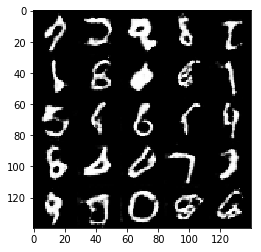

Epoch 2/2 - Batch 1010/1875:  Discriminator loss = 0.5454  Generator loss = 2.5538
Epoch 2/2 - Batch 1020/1875:  Discriminator loss = 0.5888  Generator loss = 1.8465
Epoch 2/2 - Batch 1030/1875:  Discriminator loss = 0.7378  Generator loss = 1.2473
Epoch 2/2 - Batch 1040/1875:  Discriminator loss = 0.6377  Generator loss = 1.7303
Epoch 2/2 - Batch 1050/1875:  Discriminator loss = 0.8113  Generator loss = 1.3463
Epoch 2/2 - Batch 1060/1875:  Discriminator loss = 1.1086  Generator loss = 0.8050
Epoch 2/2 - Batch 1070/1875:  Discriminator loss = 0.6710  Generator loss = 2.0863
Epoch 2/2 - Batch 1080/1875:  Discriminator loss = 0.6693  Generator loss = 1.7033
Epoch 2/2 - Batch 1090/1875:  Discriminator loss = 0.5500  Generator loss = 2.2602
Epoch 2/2 - Batch 1100/1875:  Discriminator loss = 0.6995  Generator loss = 1.5349


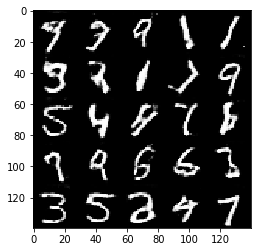

Epoch 2/2 - Batch 1110/1875:  Discriminator loss = 0.6916  Generator loss = 1.6168
Epoch 2/2 - Batch 1120/1875:  Discriminator loss = 0.7572  Generator loss = 1.4186
Epoch 2/2 - Batch 1130/1875:  Discriminator loss = 0.9970  Generator loss = 0.8616
Epoch 2/2 - Batch 1140/1875:  Discriminator loss = 0.7236  Generator loss = 1.3458
Epoch 2/2 - Batch 1150/1875:  Discriminator loss = 0.5965  Generator loss = 2.6364
Epoch 2/2 - Batch 1160/1875:  Discriminator loss = 0.9805  Generator loss = 0.9825
Epoch 2/2 - Batch 1170/1875:  Discriminator loss = 0.7840  Generator loss = 1.7635
Epoch 2/2 - Batch 1180/1875:  Discriminator loss = 0.5580  Generator loss = 2.3455
Epoch 2/2 - Batch 1190/1875:  Discriminator loss = 0.6104  Generator loss = 1.7303
Epoch 2/2 - Batch 1200/1875:  Discriminator loss = 0.6067  Generator loss = 1.8987


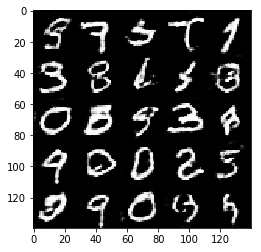

Epoch 2/2 - Batch 1210/1875:  Discriminator loss = 0.6051  Generator loss = 1.7249
Epoch 2/2 - Batch 1220/1875:  Discriminator loss = 1.5048  Generator loss = 0.4911
Epoch 2/2 - Batch 1230/1875:  Discriminator loss = 0.6952  Generator loss = 1.5302
Epoch 2/2 - Batch 1240/1875:  Discriminator loss = 0.5358  Generator loss = 2.3014
Epoch 2/2 - Batch 1250/1875:  Discriminator loss = 0.5757  Generator loss = 1.8244
Epoch 2/2 - Batch 1260/1875:  Discriminator loss = 0.8389  Generator loss = 1.1652
Epoch 2/2 - Batch 1270/1875:  Discriminator loss = 0.6125  Generator loss = 1.8956
Epoch 2/2 - Batch 1280/1875:  Discriminator loss = 0.7569  Generator loss = 1.4636
Epoch 2/2 - Batch 1290/1875:  Discriminator loss = 0.5997  Generator loss = 1.9643
Epoch 2/2 - Batch 1300/1875:  Discriminator loss = 0.7018  Generator loss = 3.1054


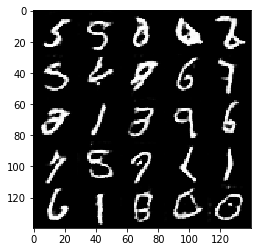

Epoch 2/2 - Batch 1310/1875:  Discriminator loss = 0.7258  Generator loss = 1.3940
Epoch 2/2 - Batch 1320/1875:  Discriminator loss = 0.7516  Generator loss = 1.3606
Epoch 2/2 - Batch 1330/1875:  Discriminator loss = 1.0851  Generator loss = 0.8217
Epoch 2/2 - Batch 1340/1875:  Discriminator loss = 1.4811  Generator loss = 0.5006
Epoch 2/2 - Batch 1350/1875:  Discriminator loss = 0.5298  Generator loss = 2.0651
Epoch 2/2 - Batch 1360/1875:  Discriminator loss = 0.7165  Generator loss = 1.3772
Epoch 2/2 - Batch 1370/1875:  Discriminator loss = 0.6537  Generator loss = 1.4816
Epoch 2/2 - Batch 1380/1875:  Discriminator loss = 0.5677  Generator loss = 1.8406
Epoch 2/2 - Batch 1390/1875:  Discriminator loss = 0.5778  Generator loss = 1.7714
Epoch 2/2 - Batch 1400/1875:  Discriminator loss = 0.5140  Generator loss = 3.3545


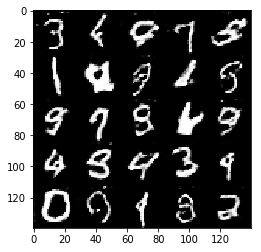

Epoch 2/2 - Batch 1410/1875:  Discriminator loss = 0.8461  Generator loss = 1.1226
Epoch 2/2 - Batch 1420/1875:  Discriminator loss = 0.5381  Generator loss = 2.0878
Epoch 2/2 - Batch 1430/1875:  Discriminator loss = 0.6538  Generator loss = 1.6908
Epoch 2/2 - Batch 1440/1875:  Discriminator loss = 0.9375  Generator loss = 1.0132
Epoch 2/2 - Batch 1450/1875:  Discriminator loss = 0.4660  Generator loss = 2.7287
Epoch 2/2 - Batch 1460/1875:  Discriminator loss = 0.7132  Generator loss = 1.3317
Epoch 2/2 - Batch 1470/1875:  Discriminator loss = 0.4688  Generator loss = 2.4516
Epoch 2/2 - Batch 1480/1875:  Discriminator loss = 1.0568  Generator loss = 0.7902
Epoch 2/2 - Batch 1490/1875:  Discriminator loss = 0.7281  Generator loss = 1.3626
Epoch 2/2 - Batch 1500/1875:  Discriminator loss = 1.1123  Generator loss = 0.8091


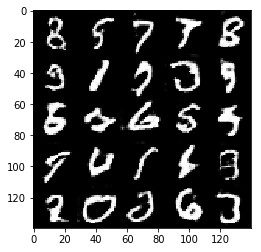

Epoch 2/2 - Batch 1510/1875:  Discriminator loss = 0.6835  Generator loss = 1.9822
Epoch 2/2 - Batch 1520/1875:  Discriminator loss = 0.5551  Generator loss = 2.4147
Epoch 2/2 - Batch 1530/1875:  Discriminator loss = 1.5614  Generator loss = 0.4789
Epoch 2/2 - Batch 1540/1875:  Discriminator loss = 0.6086  Generator loss = 2.7842
Epoch 2/2 - Batch 1550/1875:  Discriminator loss = 0.5793  Generator loss = 2.1556
Epoch 2/2 - Batch 1560/1875:  Discriminator loss = 0.5580  Generator loss = 2.1114
Epoch 2/2 - Batch 1570/1875:  Discriminator loss = 0.7569  Generator loss = 1.3257
Epoch 2/2 - Batch 1580/1875:  Discriminator loss = 1.8731  Generator loss = 5.7590
Epoch 2/2 - Batch 1590/1875:  Discriminator loss = 0.9770  Generator loss = 1.0130
Epoch 2/2 - Batch 1600/1875:  Discriminator loss = 0.7689  Generator loss = 1.2504


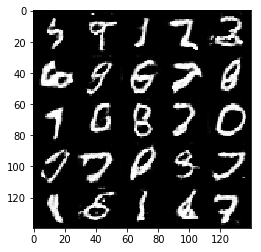

Epoch 2/2 - Batch 1610/1875:  Discriminator loss = 0.7819  Generator loss = 1.2469
Epoch 2/2 - Batch 1620/1875:  Discriminator loss = 0.6276  Generator loss = 1.7461
Epoch 2/2 - Batch 1630/1875:  Discriminator loss = 0.5239  Generator loss = 2.1705
Epoch 2/2 - Batch 1640/1875:  Discriminator loss = 0.6961  Generator loss = 1.4507
Epoch 2/2 - Batch 1650/1875:  Discriminator loss = 0.9170  Generator loss = 0.9647
Epoch 2/2 - Batch 1660/1875:  Discriminator loss = 0.5358  Generator loss = 2.0928
Epoch 2/2 - Batch 1670/1875:  Discriminator loss = 0.5804  Generator loss = 1.9175
Epoch 2/2 - Batch 1680/1875:  Discriminator loss = 0.6119  Generator loss = 1.5573
Epoch 2/2 - Batch 1690/1875:  Discriminator loss = 0.7615  Generator loss = 1.2944
Epoch 2/2 - Batch 1700/1875:  Discriminator loss = 1.0558  Generator loss = 0.7769


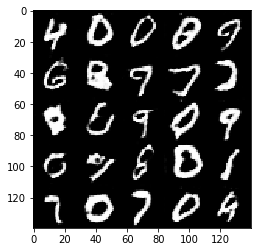

Epoch 2/2 - Batch 1710/1875:  Discriminator loss = 0.6795  Generator loss = 1.5559
Epoch 2/2 - Batch 1720/1875:  Discriminator loss = 0.5624  Generator loss = 1.8687
Epoch 2/2 - Batch 1730/1875:  Discriminator loss = 0.6140  Generator loss = 2.3723
Epoch 2/2 - Batch 1740/1875:  Discriminator loss = 0.5665  Generator loss = 2.3366
Epoch 2/2 - Batch 1750/1875:  Discriminator loss = 1.1199  Generator loss = 0.8184
Epoch 2/2 - Batch 1760/1875:  Discriminator loss = 1.9552  Generator loss = 5.3658
Epoch 2/2 - Batch 1770/1875:  Discriminator loss = 0.5120  Generator loss = 2.2064
Epoch 2/2 - Batch 1780/1875:  Discriminator loss = 0.6401  Generator loss = 1.8088
Epoch 2/2 - Batch 1790/1875:  Discriminator loss = 0.8939  Generator loss = 1.0739
Epoch 2/2 - Batch 1800/1875:  Discriminator loss = 0.5350  Generator loss = 2.9428


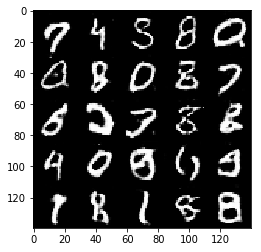

Epoch 2/2 - Batch 1810/1875:  Discriminator loss = 1.4700  Generator loss = 0.6426
Epoch 2/2 - Batch 1820/1875:  Discriminator loss = 0.6537  Generator loss = 1.6922
Epoch 2/2 - Batch 1830/1875:  Discriminator loss = 0.5616  Generator loss = 2.0031
Epoch 2/2 - Batch 1840/1875:  Discriminator loss = 0.5196  Generator loss = 2.5688
Epoch 2/2 - Batch 1850/1875:  Discriminator loss = 0.5667  Generator loss = 1.9316
Epoch 2/2 - Batch 1860/1875:  Discriminator loss = 0.4935  Generator loss = 2.5372
Epoch 2/2 - Batch 1870/1875:  Discriminator loss = 0.6802  Generator loss = 1.5119


In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
n_images = 25


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Finally here we will run the GANs on the CelebA dataset.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 - Batch 10/6331:  Discriminator loss = 1.0841  Generator loss = 0.7759
Epoch 1/1 - Batch 20/6331:  Discriminator loss = 0.4378  Generator loss = 3.0005
Epoch 1/1 - Batch 30/6331:  Discriminator loss = 0.6064  Generator loss = 1.8378
Epoch 1/1 - Batch 40/6331:  Discriminator loss = 0.6673  Generator loss = 3.5596
Epoch 1/1 - Batch 50/6331:  Discriminator loss = 0.9218  Generator loss = 12.3015
Epoch 1/1 - Batch 60/6331:  Discriminator loss = 1.0199  Generator loss = 1.0468
Epoch 1/1 - Batch 70/6331:  Discriminator loss = 0.6252  Generator loss = 1.8586
Epoch 1/1 - Batch 80/6331:  Discriminator loss = 0.6247  Generator loss = 2.1168
Epoch 1/1 - Batch 90/6331:  Discriminator loss = 0.7562  Generator loss = 2.1899
Epoch 1/1 - Batch 100/6331:  Discriminator loss = 0.6778  Generator loss = 2.1671


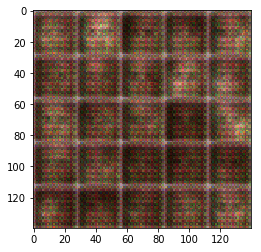

Epoch 1/1 - Batch 110/6331:  Discriminator loss = 0.8364  Generator loss = 3.3755
Epoch 1/1 - Batch 120/6331:  Discriminator loss = 0.8577  Generator loss = 1.1950
Epoch 1/1 - Batch 130/6331:  Discriminator loss = 0.9896  Generator loss = 0.9231
Epoch 1/1 - Batch 140/6331:  Discriminator loss = 0.8143  Generator loss = 4.0523
Epoch 1/1 - Batch 150/6331:  Discriminator loss = 0.5630  Generator loss = 2.6952
Epoch 1/1 - Batch 160/6331:  Discriminator loss = 0.8171  Generator loss = 1.2765
Epoch 1/1 - Batch 170/6331:  Discriminator loss = 0.5475  Generator loss = 2.3069
Epoch 1/1 - Batch 180/6331:  Discriminator loss = 0.8182  Generator loss = 1.5683
Epoch 1/1 - Batch 190/6331:  Discriminator loss = 1.0891  Generator loss = 0.8460
Epoch 1/1 - Batch 200/6331:  Discriminator loss = 0.5456  Generator loss = 2.4926


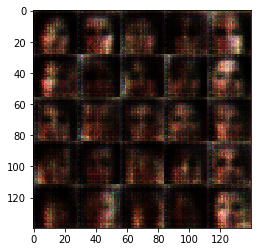

Epoch 1/1 - Batch 210/6331:  Discriminator loss = 0.5920  Generator loss = 2.3617
Epoch 1/1 - Batch 220/6331:  Discriminator loss = 0.5191  Generator loss = 2.6883
Epoch 1/1 - Batch 230/6331:  Discriminator loss = 0.9179  Generator loss = 1.7950
Epoch 1/1 - Batch 240/6331:  Discriminator loss = 0.9628  Generator loss = 1.0026
Epoch 1/1 - Batch 250/6331:  Discriminator loss = 0.7165  Generator loss = 1.6222
Epoch 1/1 - Batch 260/6331:  Discriminator loss = 0.6375  Generator loss = 1.9923
Epoch 1/1 - Batch 270/6331:  Discriminator loss = 1.0229  Generator loss = 1.9462
Epoch 1/1 - Batch 280/6331:  Discriminator loss = 0.9800  Generator loss = 1.9914
Epoch 1/1 - Batch 290/6331:  Discriminator loss = 0.7244  Generator loss = 1.6485
Epoch 1/1 - Batch 300/6331:  Discriminator loss = 1.4550  Generator loss = 0.6320


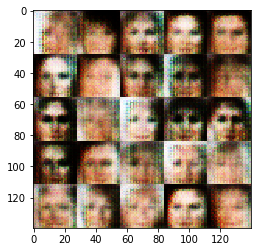

Epoch 1/1 - Batch 310/6331:  Discriminator loss = 1.2033  Generator loss = 0.6834
Epoch 1/1 - Batch 320/6331:  Discriminator loss = 0.9750  Generator loss = 1.1127
Epoch 1/1 - Batch 330/6331:  Discriminator loss = 1.4723  Generator loss = 0.5411
Epoch 1/1 - Batch 340/6331:  Discriminator loss = 1.0633  Generator loss = 2.1478
Epoch 1/1 - Batch 350/6331:  Discriminator loss = 0.7278  Generator loss = 1.4472
Epoch 1/1 - Batch 360/6331:  Discriminator loss = 1.6033  Generator loss = 0.4265
Epoch 1/1 - Batch 370/6331:  Discriminator loss = 0.8242  Generator loss = 1.3466
Epoch 1/1 - Batch 380/6331:  Discriminator loss = 0.6984  Generator loss = 2.6557
Epoch 1/1 - Batch 390/6331:  Discriminator loss = 0.8172  Generator loss = 1.2877
Epoch 1/1 - Batch 400/6331:  Discriminator loss = 1.2578  Generator loss = 0.7889


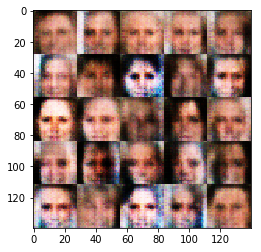

Epoch 1/1 - Batch 410/6331:  Discriminator loss = 0.7213  Generator loss = 1.5319
Epoch 1/1 - Batch 420/6331:  Discriminator loss = 1.1576  Generator loss = 3.8724
Epoch 1/1 - Batch 430/6331:  Discriminator loss = 0.8017  Generator loss = 2.0172
Epoch 1/1 - Batch 440/6331:  Discriminator loss = 1.0812  Generator loss = 1.8601
Epoch 1/1 - Batch 450/6331:  Discriminator loss = 1.0065  Generator loss = 2.2430
Epoch 1/1 - Batch 460/6331:  Discriminator loss = 0.8535  Generator loss = 2.0164
Epoch 1/1 - Batch 470/6331:  Discriminator loss = 1.0360  Generator loss = 1.3134
Epoch 1/1 - Batch 480/6331:  Discriminator loss = 1.0202  Generator loss = 2.3369
Epoch 1/1 - Batch 490/6331:  Discriminator loss = 1.2021  Generator loss = 0.7477
Epoch 1/1 - Batch 500/6331:  Discriminator loss = 0.9819  Generator loss = 1.2203


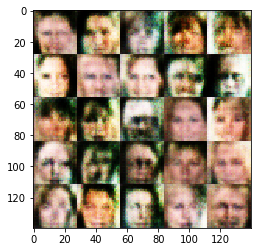

Epoch 1/1 - Batch 510/6331:  Discriminator loss = 1.3060  Generator loss = 0.6030
Epoch 1/1 - Batch 520/6331:  Discriminator loss = 1.1275  Generator loss = 0.7981
Epoch 1/1 - Batch 530/6331:  Discriminator loss = 1.1961  Generator loss = 0.6954
Epoch 1/1 - Batch 540/6331:  Discriminator loss = 1.1146  Generator loss = 3.3117
Epoch 1/1 - Batch 550/6331:  Discriminator loss = 0.8552  Generator loss = 1.4846
Epoch 1/1 - Batch 560/6331:  Discriminator loss = 0.8187  Generator loss = 1.3829
Epoch 1/1 - Batch 570/6331:  Discriminator loss = 0.9739  Generator loss = 1.6186
Epoch 1/1 - Batch 580/6331:  Discriminator loss = 1.3223  Generator loss = 2.3785
Epoch 1/1 - Batch 590/6331:  Discriminator loss = 2.3806  Generator loss = 0.1745
Epoch 1/1 - Batch 600/6331:  Discriminator loss = 1.6845  Generator loss = 0.4410


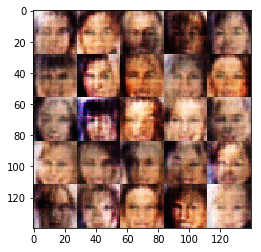

Epoch 1/1 - Batch 610/6331:  Discriminator loss = 0.9257  Generator loss = 1.6574
Epoch 1/1 - Batch 620/6331:  Discriminator loss = 0.8399  Generator loss = 1.7977
Epoch 1/1 - Batch 630/6331:  Discriminator loss = 1.3154  Generator loss = 0.6343
Epoch 1/1 - Batch 640/6331:  Discriminator loss = 0.8838  Generator loss = 1.8256
Epoch 1/1 - Batch 650/6331:  Discriminator loss = 0.8481  Generator loss = 1.3188
Epoch 1/1 - Batch 660/6331:  Discriminator loss = 1.0202  Generator loss = 1.0510
Epoch 1/1 - Batch 670/6331:  Discriminator loss = 1.0933  Generator loss = 0.9217
Epoch 1/1 - Batch 680/6331:  Discriminator loss = 1.0977  Generator loss = 1.8109
Epoch 1/1 - Batch 690/6331:  Discriminator loss = 1.0059  Generator loss = 1.1254
Epoch 1/1 - Batch 700/6331:  Discriminator loss = 1.1072  Generator loss = 0.8596


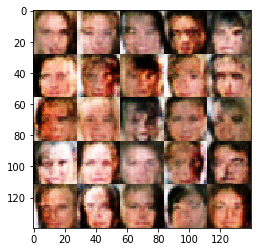

Epoch 1/1 - Batch 710/6331:  Discriminator loss = 1.2171  Generator loss = 0.7583
Epoch 1/1 - Batch 720/6331:  Discriminator loss = 1.0870  Generator loss = 1.1508
Epoch 1/1 - Batch 730/6331:  Discriminator loss = 1.1043  Generator loss = 1.9475
Epoch 1/1 - Batch 740/6331:  Discriminator loss = 1.0711  Generator loss = 1.1452
Epoch 1/1 - Batch 750/6331:  Discriminator loss = 0.9447  Generator loss = 1.0398
Epoch 1/1 - Batch 760/6331:  Discriminator loss = 1.0992  Generator loss = 0.8140
Epoch 1/1 - Batch 770/6331:  Discriminator loss = 0.9613  Generator loss = 1.4142
Epoch 1/1 - Batch 780/6331:  Discriminator loss = 1.1125  Generator loss = 0.9924
Epoch 1/1 - Batch 790/6331:  Discriminator loss = 0.9883  Generator loss = 1.0113
Epoch 1/1 - Batch 800/6331:  Discriminator loss = 0.8785  Generator loss = 1.7256


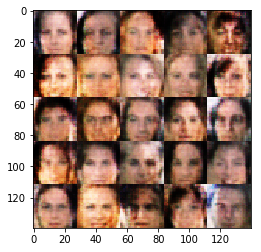

Epoch 1/1 - Batch 810/6331:  Discriminator loss = 1.2407  Generator loss = 0.6545
Epoch 1/1 - Batch 820/6331:  Discriminator loss = 1.3450  Generator loss = 2.9797
Epoch 1/1 - Batch 830/6331:  Discriminator loss = 0.9180  Generator loss = 1.1856
Epoch 1/1 - Batch 840/6331:  Discriminator loss = 0.9883  Generator loss = 1.4776
Epoch 1/1 - Batch 850/6331:  Discriminator loss = 1.0213  Generator loss = 1.0469
Epoch 1/1 - Batch 860/6331:  Discriminator loss = 2.0600  Generator loss = 3.5068
Epoch 1/1 - Batch 870/6331:  Discriminator loss = 1.0816  Generator loss = 0.9152
Epoch 1/1 - Batch 880/6331:  Discriminator loss = 1.0845  Generator loss = 1.3950
Epoch 1/1 - Batch 890/6331:  Discriminator loss = 0.9886  Generator loss = 1.5640
Epoch 1/1 - Batch 900/6331:  Discriminator loss = 1.1059  Generator loss = 0.8601


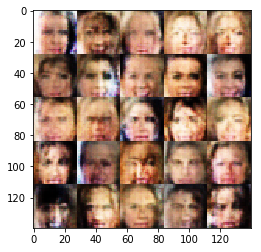

Epoch 1/1 - Batch 910/6331:  Discriminator loss = 0.9599  Generator loss = 0.9625
Epoch 1/1 - Batch 920/6331:  Discriminator loss = 1.2433  Generator loss = 0.7641
Epoch 1/1 - Batch 930/6331:  Discriminator loss = 1.1827  Generator loss = 0.7456
Epoch 1/1 - Batch 940/6331:  Discriminator loss = 0.8522  Generator loss = 1.5097
Epoch 1/1 - Batch 950/6331:  Discriminator loss = 0.7387  Generator loss = 1.8433
Epoch 1/1 - Batch 960/6331:  Discriminator loss = 1.0593  Generator loss = 0.9200
Epoch 1/1 - Batch 970/6331:  Discriminator loss = 1.2568  Generator loss = 0.6863
Epoch 1/1 - Batch 980/6331:  Discriminator loss = 1.0565  Generator loss = 1.5999
Epoch 1/1 - Batch 990/6331:  Discriminator loss = 1.1245  Generator loss = 2.3157
Epoch 1/1 - Batch 1000/6331:  Discriminator loss = 1.1296  Generator loss = 1.7477


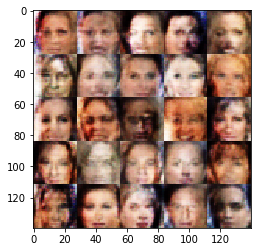

Epoch 1/1 - Batch 1010/6331:  Discriminator loss = 1.0642  Generator loss = 1.5813
Epoch 1/1 - Batch 1020/6331:  Discriminator loss = 1.0509  Generator loss = 0.9205
Epoch 1/1 - Batch 1030/6331:  Discriminator loss = 1.4833  Generator loss = 0.4960
Epoch 1/1 - Batch 1040/6331:  Discriminator loss = 1.1277  Generator loss = 0.7812
Epoch 1/1 - Batch 1050/6331:  Discriminator loss = 1.0583  Generator loss = 0.9020
Epoch 1/1 - Batch 1060/6331:  Discriminator loss = 0.9610  Generator loss = 1.2992
Epoch 1/1 - Batch 1070/6331:  Discriminator loss = 0.9438  Generator loss = 1.2932
Epoch 1/1 - Batch 1080/6331:  Discriminator loss = 0.9866  Generator loss = 1.7177
Epoch 1/1 - Batch 1090/6331:  Discriminator loss = 0.8946  Generator loss = 1.8130
Epoch 1/1 - Batch 1100/6331:  Discriminator loss = 1.1567  Generator loss = 0.9948


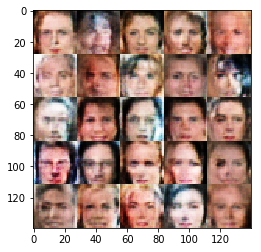

Epoch 1/1 - Batch 1110/6331:  Discriminator loss = 1.2853  Generator loss = 0.6092
Epoch 1/1 - Batch 1120/6331:  Discriminator loss = 0.8214  Generator loss = 1.6842
Epoch 1/1 - Batch 1130/6331:  Discriminator loss = 1.2480  Generator loss = 0.8755
Epoch 1/1 - Batch 1140/6331:  Discriminator loss = 0.9477  Generator loss = 1.1161
Epoch 1/1 - Batch 1150/6331:  Discriminator loss = 0.8726  Generator loss = 1.4460
Epoch 1/1 - Batch 1160/6331:  Discriminator loss = 1.1865  Generator loss = 0.6595
Epoch 1/1 - Batch 1170/6331:  Discriminator loss = 1.1219  Generator loss = 0.8096
Epoch 1/1 - Batch 1180/6331:  Discriminator loss = 1.0027  Generator loss = 1.3695
Epoch 1/1 - Batch 1190/6331:  Discriminator loss = 1.4158  Generator loss = 0.5480
Epoch 1/1 - Batch 1200/6331:  Discriminator loss = 0.9967  Generator loss = 1.7591


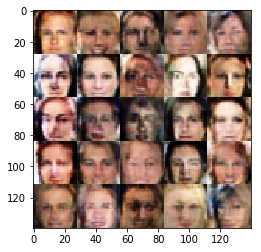

Epoch 1/1 - Batch 1210/6331:  Discriminator loss = 1.6492  Generator loss = 0.3941
Epoch 1/1 - Batch 1220/6331:  Discriminator loss = 0.9950  Generator loss = 0.9389
Epoch 1/1 - Batch 1230/6331:  Discriminator loss = 1.1718  Generator loss = 0.6988
Epoch 1/1 - Batch 1240/6331:  Discriminator loss = 0.9444  Generator loss = 1.2022
Epoch 1/1 - Batch 1250/6331:  Discriminator loss = 0.9262  Generator loss = 1.2194
Epoch 1/1 - Batch 1260/6331:  Discriminator loss = 1.1084  Generator loss = 0.7877
Epoch 1/1 - Batch 1270/6331:  Discriminator loss = 0.8480  Generator loss = 1.7169
Epoch 1/1 - Batch 1280/6331:  Discriminator loss = 0.9300  Generator loss = 1.2143
Epoch 1/1 - Batch 1290/6331:  Discriminator loss = 1.1421  Generator loss = 0.8624
Epoch 1/1 - Batch 1300/6331:  Discriminator loss = 0.9786  Generator loss = 2.1982


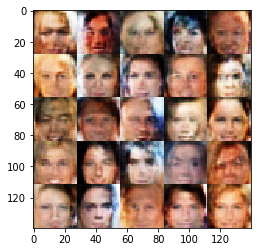

Epoch 1/1 - Batch 1310/6331:  Discriminator loss = 1.0972  Generator loss = 0.7773
Epoch 1/1 - Batch 1320/6331:  Discriminator loss = 1.2982  Generator loss = 0.5656
Epoch 1/1 - Batch 1330/6331:  Discriminator loss = 0.8803  Generator loss = 1.4724
Epoch 1/1 - Batch 1340/6331:  Discriminator loss = 1.0051  Generator loss = 1.9029
Epoch 1/1 - Batch 1350/6331:  Discriminator loss = 0.8586  Generator loss = 1.6957
Epoch 1/1 - Batch 1360/6331:  Discriminator loss = 1.6282  Generator loss = 2.7624
Epoch 1/1 - Batch 1370/6331:  Discriminator loss = 0.7655  Generator loss = 1.6545
Epoch 1/1 - Batch 1380/6331:  Discriminator loss = 1.3177  Generator loss = 0.6440
Epoch 1/1 - Batch 1390/6331:  Discriminator loss = 1.2413  Generator loss = 0.6991
Epoch 1/1 - Batch 1400/6331:  Discriminator loss = 1.0567  Generator loss = 2.0325


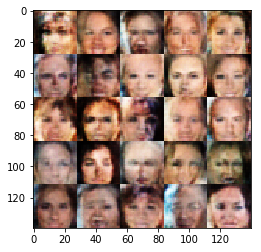

Epoch 1/1 - Batch 1410/6331:  Discriminator loss = 1.1026  Generator loss = 1.5393
Epoch 1/1 - Batch 1420/6331:  Discriminator loss = 0.8685  Generator loss = 1.6432
Epoch 1/1 - Batch 1430/6331:  Discriminator loss = 0.9262  Generator loss = 1.1691
Epoch 1/1 - Batch 1440/6331:  Discriminator loss = 1.3386  Generator loss = 0.5743
Epoch 1/1 - Batch 1450/6331:  Discriminator loss = 0.8582  Generator loss = 1.1046
Epoch 1/1 - Batch 1460/6331:  Discriminator loss = 1.1568  Generator loss = 0.8747
Epoch 1/1 - Batch 1470/6331:  Discriminator loss = 0.8675  Generator loss = 1.5770
Epoch 1/1 - Batch 1480/6331:  Discriminator loss = 1.1024  Generator loss = 0.7036
Epoch 1/1 - Batch 1490/6331:  Discriminator loss = 1.0650  Generator loss = 0.8050
Epoch 1/1 - Batch 1500/6331:  Discriminator loss = 1.1537  Generator loss = 0.7695


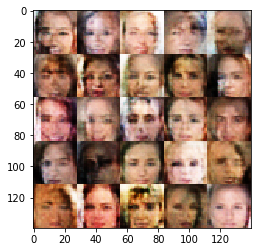

Epoch 1/1 - Batch 1510/6331:  Discriminator loss = 1.2021  Generator loss = 0.9664
Epoch 1/1 - Batch 1520/6331:  Discriminator loss = 1.0104  Generator loss = 1.1978
Epoch 1/1 - Batch 1530/6331:  Discriminator loss = 0.9074  Generator loss = 1.6202
Epoch 1/1 - Batch 1540/6331:  Discriminator loss = 1.0456  Generator loss = 0.8884
Epoch 1/1 - Batch 1550/6331:  Discriminator loss = 1.0205  Generator loss = 0.9722
Epoch 1/1 - Batch 1560/6331:  Discriminator loss = 0.9607  Generator loss = 1.4000
Epoch 1/1 - Batch 1570/6331:  Discriminator loss = 1.0519  Generator loss = 1.3774
Epoch 1/1 - Batch 1580/6331:  Discriminator loss = 1.1582  Generator loss = 0.7916
Epoch 1/1 - Batch 1590/6331:  Discriminator loss = 0.8388  Generator loss = 1.3742
Epoch 1/1 - Batch 1600/6331:  Discriminator loss = 1.2432  Generator loss = 0.5680


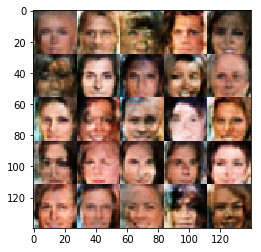

Epoch 1/1 - Batch 1610/6331:  Discriminator loss = 1.2448  Generator loss = 0.7380
Epoch 1/1 - Batch 1620/6331:  Discriminator loss = 1.1518  Generator loss = 2.2703
Epoch 1/1 - Batch 1630/6331:  Discriminator loss = 1.4533  Generator loss = 0.5312
Epoch 1/1 - Batch 1640/6331:  Discriminator loss = 1.0711  Generator loss = 1.1360
Epoch 1/1 - Batch 1650/6331:  Discriminator loss = 1.1790  Generator loss = 0.6695
Epoch 1/1 - Batch 1660/6331:  Discriminator loss = 0.7857  Generator loss = 1.9069
Epoch 1/1 - Batch 1670/6331:  Discriminator loss = 1.0339  Generator loss = 0.9465
Epoch 1/1 - Batch 1680/6331:  Discriminator loss = 0.9073  Generator loss = 1.1057
Epoch 1/1 - Batch 1690/6331:  Discriminator loss = 1.3090  Generator loss = 0.6288
Epoch 1/1 - Batch 1700/6331:  Discriminator loss = 1.0206  Generator loss = 0.9130


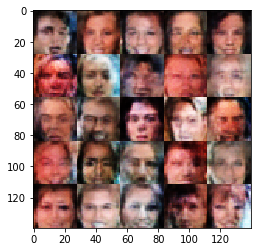

Epoch 1/1 - Batch 1710/6331:  Discriminator loss = 0.9347  Generator loss = 1.8034
Epoch 1/1 - Batch 1720/6331:  Discriminator loss = 1.2297  Generator loss = 0.6171
Epoch 1/1 - Batch 1730/6331:  Discriminator loss = 1.5198  Generator loss = 0.4455
Epoch 1/1 - Batch 1740/6331:  Discriminator loss = 0.9497  Generator loss = 1.0495
Epoch 1/1 - Batch 1750/6331:  Discriminator loss = 0.7876  Generator loss = 1.4892
Epoch 1/1 - Batch 1760/6331:  Discriminator loss = 0.7658  Generator loss = 1.4554
Epoch 1/1 - Batch 1770/6331:  Discriminator loss = 1.2480  Generator loss = 0.6220
Epoch 1/1 - Batch 1780/6331:  Discriminator loss = 1.3335  Generator loss = 0.5723
Epoch 1/1 - Batch 1790/6331:  Discriminator loss = 0.8937  Generator loss = 1.3436
Epoch 1/1 - Batch 1800/6331:  Discriminator loss = 1.1528  Generator loss = 0.7200


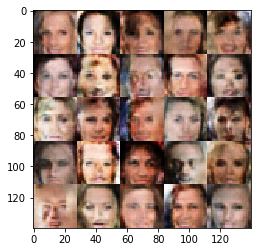

Epoch 1/1 - Batch 1810/6331:  Discriminator loss = 0.8998  Generator loss = 1.3150
Epoch 1/1 - Batch 1820/6331:  Discriminator loss = 1.3239  Generator loss = 0.5816
Epoch 1/1 - Batch 1830/6331:  Discriminator loss = 1.0225  Generator loss = 1.0071
Epoch 1/1 - Batch 1840/6331:  Discriminator loss = 1.4525  Generator loss = 0.5984
Epoch 1/1 - Batch 1850/6331:  Discriminator loss = 1.4164  Generator loss = 0.5064
Epoch 1/1 - Batch 1860/6331:  Discriminator loss = 1.0191  Generator loss = 2.1295
Epoch 1/1 - Batch 1870/6331:  Discriminator loss = 0.7798  Generator loss = 1.3178
Epoch 1/1 - Batch 1880/6331:  Discriminator loss = 1.1839  Generator loss = 0.7393
Epoch 1/1 - Batch 1890/6331:  Discriminator loss = 1.4115  Generator loss = 0.5251
Epoch 1/1 - Batch 1900/6331:  Discriminator loss = 1.3175  Generator loss = 0.5583


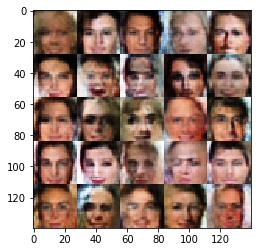

Epoch 1/1 - Batch 1910/6331:  Discriminator loss = 0.8959  Generator loss = 1.6526
Epoch 1/1 - Batch 1920/6331:  Discriminator loss = 0.6910  Generator loss = 1.5628
Epoch 1/1 - Batch 1930/6331:  Discriminator loss = 0.8962  Generator loss = 0.9536
Epoch 1/1 - Batch 1940/6331:  Discriminator loss = 0.9521  Generator loss = 1.0379
Epoch 1/1 - Batch 1950/6331:  Discriminator loss = 1.1720  Generator loss = 0.6907
Epoch 1/1 - Batch 1960/6331:  Discriminator loss = 1.0368  Generator loss = 0.7841
Epoch 1/1 - Batch 1970/6331:  Discriminator loss = 0.5944  Generator loss = 2.2014
Epoch 1/1 - Batch 1980/6331:  Discriminator loss = 0.8657  Generator loss = 1.2498
Epoch 1/1 - Batch 1990/6331:  Discriminator loss = 2.1066  Generator loss = 0.2476
Epoch 1/1 - Batch 2000/6331:  Discriminator loss = 1.2138  Generator loss = 2.0037


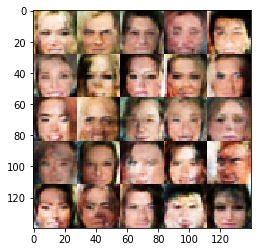

Epoch 1/1 - Batch 2010/6331:  Discriminator loss = 0.7345  Generator loss = 2.4153
Epoch 1/1 - Batch 2020/6331:  Discriminator loss = 0.7429  Generator loss = 2.0225
Epoch 1/1 - Batch 2030/6331:  Discriminator loss = 0.8935  Generator loss = 0.9820
Epoch 1/1 - Batch 2040/6331:  Discriminator loss = 0.7644  Generator loss = 1.7767
Epoch 1/1 - Batch 2050/6331:  Discriminator loss = 0.7962  Generator loss = 1.6846
Epoch 1/1 - Batch 2060/6331:  Discriminator loss = 0.7816  Generator loss = 1.5580
Epoch 1/1 - Batch 2070/6331:  Discriminator loss = 1.0561  Generator loss = 1.1651
Epoch 1/1 - Batch 2080/6331:  Discriminator loss = 1.1877  Generator loss = 0.7585
Epoch 1/1 - Batch 2090/6331:  Discriminator loss = 0.8470  Generator loss = 1.8877
Epoch 1/1 - Batch 2100/6331:  Discriminator loss = 1.0745  Generator loss = 2.4132


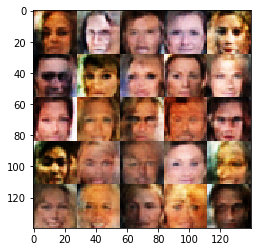

Epoch 1/1 - Batch 2110/6331:  Discriminator loss = 0.9418  Generator loss = 1.2120
Epoch 1/1 - Batch 2120/6331:  Discriminator loss = 1.1179  Generator loss = 0.7280
Epoch 1/1 - Batch 2130/6331:  Discriminator loss = 0.8879  Generator loss = 1.6332
Epoch 1/1 - Batch 2140/6331:  Discriminator loss = 1.4132  Generator loss = 0.5083
Epoch 1/1 - Batch 2150/6331:  Discriminator loss = 0.6594  Generator loss = 1.5901
Epoch 1/1 - Batch 2160/6331:  Discriminator loss = 0.7310  Generator loss = 1.6492
Epoch 1/1 - Batch 2170/6331:  Discriminator loss = 1.2609  Generator loss = 0.6148
Epoch 1/1 - Batch 2180/6331:  Discriminator loss = 0.8679  Generator loss = 1.1673
Epoch 1/1 - Batch 2190/6331:  Discriminator loss = 0.8455  Generator loss = 1.8063
Epoch 1/1 - Batch 2200/6331:  Discriminator loss = 0.9377  Generator loss = 2.0227


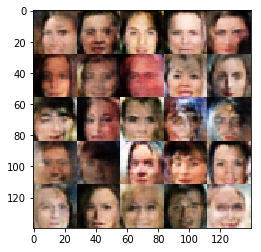

Epoch 1/1 - Batch 2210/6331:  Discriminator loss = 1.0036  Generator loss = 0.9572
Epoch 1/1 - Batch 2220/6331:  Discriminator loss = 0.8599  Generator loss = 1.0901
Epoch 1/1 - Batch 2230/6331:  Discriminator loss = 0.6232  Generator loss = 1.8853
Epoch 1/1 - Batch 2240/6331:  Discriminator loss = 0.7416  Generator loss = 2.3485
Epoch 1/1 - Batch 2250/6331:  Discriminator loss = 1.1621  Generator loss = 0.7117
Epoch 1/1 - Batch 2260/6331:  Discriminator loss = 0.9771  Generator loss = 0.9021
Epoch 1/1 - Batch 2270/6331:  Discriminator loss = 0.7841  Generator loss = 1.3139
Epoch 1/1 - Batch 2280/6331:  Discriminator loss = 0.7054  Generator loss = 1.6867
Epoch 1/1 - Batch 2290/6331:  Discriminator loss = 1.1302  Generator loss = 1.1440
Epoch 1/1 - Batch 2300/6331:  Discriminator loss = 1.1031  Generator loss = 0.7408


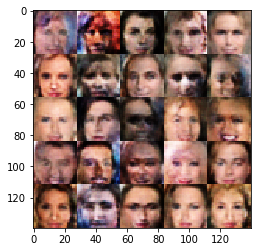

Epoch 1/1 - Batch 2310/6331:  Discriminator loss = 0.8336  Generator loss = 1.2378
Epoch 1/1 - Batch 2320/6331:  Discriminator loss = 1.0555  Generator loss = 0.7699
Epoch 1/1 - Batch 2330/6331:  Discriminator loss = 0.9438  Generator loss = 1.0644
Epoch 1/1 - Batch 2340/6331:  Discriminator loss = 0.9040  Generator loss = 0.9905
Epoch 1/1 - Batch 2350/6331:  Discriminator loss = 1.1127  Generator loss = 0.9861
Epoch 1/1 - Batch 2360/6331:  Discriminator loss = 1.4278  Generator loss = 0.5213
Epoch 1/1 - Batch 2370/6331:  Discriminator loss = 0.7716  Generator loss = 1.8969
Epoch 1/1 - Batch 2380/6331:  Discriminator loss = 1.7507  Generator loss = 0.3475
Epoch 1/1 - Batch 2390/6331:  Discriminator loss = 0.8068  Generator loss = 1.4432
Epoch 1/1 - Batch 2400/6331:  Discriminator loss = 1.1422  Generator loss = 0.8760


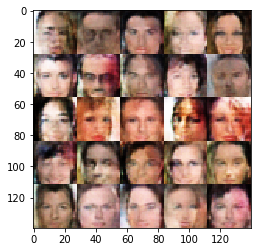

Epoch 1/1 - Batch 2410/6331:  Discriminator loss = 1.4393  Generator loss = 0.4661
Epoch 1/1 - Batch 2420/6331:  Discriminator loss = 0.8418  Generator loss = 1.2618
Epoch 1/1 - Batch 2430/6331:  Discriminator loss = 1.2670  Generator loss = 0.5637
Epoch 1/1 - Batch 2440/6331:  Discriminator loss = 1.0366  Generator loss = 0.9496
Epoch 1/1 - Batch 2450/6331:  Discriminator loss = 0.6805  Generator loss = 1.4565
Epoch 1/1 - Batch 2460/6331:  Discriminator loss = 0.8855  Generator loss = 1.2856
Epoch 1/1 - Batch 2470/6331:  Discriminator loss = 0.7803  Generator loss = 1.3053
Epoch 1/1 - Batch 2480/6331:  Discriminator loss = 0.9544  Generator loss = 1.8493
Epoch 1/1 - Batch 2490/6331:  Discriminator loss = 0.6321  Generator loss = 1.6763
Epoch 1/1 - Batch 2500/6331:  Discriminator loss = 0.7356  Generator loss = 1.3801


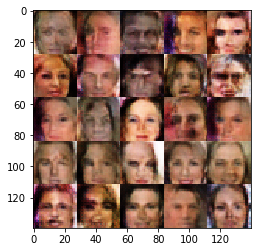

Epoch 1/1 - Batch 2510/6331:  Discriminator loss = 0.8975  Generator loss = 1.9623
Epoch 1/1 - Batch 2520/6331:  Discriminator loss = 0.8040  Generator loss = 1.4846
Epoch 1/1 - Batch 2530/6331:  Discriminator loss = 0.7778  Generator loss = 1.4146
Epoch 1/1 - Batch 2540/6331:  Discriminator loss = 0.9025  Generator loss = 1.0169
Epoch 1/1 - Batch 2550/6331:  Discriminator loss = 0.9963  Generator loss = 0.9280
Epoch 1/1 - Batch 2560/6331:  Discriminator loss = 0.6958  Generator loss = 1.7332
Epoch 1/1 - Batch 2570/6331:  Discriminator loss = 0.9922  Generator loss = 0.8612
Epoch 1/1 - Batch 2580/6331:  Discriminator loss = 0.8636  Generator loss = 1.0496
Epoch 1/1 - Batch 2590/6331:  Discriminator loss = 1.4660  Generator loss = 0.4440
Epoch 1/1 - Batch 2600/6331:  Discriminator loss = 1.2720  Generator loss = 0.6112


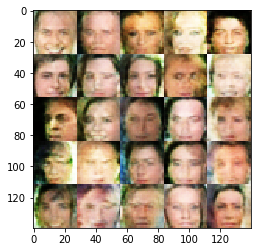

Epoch 1/1 - Batch 2610/6331:  Discriminator loss = 0.7298  Generator loss = 1.4298
Epoch 1/1 - Batch 2620/6331:  Discriminator loss = 0.9999  Generator loss = 0.9272
Epoch 1/1 - Batch 2630/6331:  Discriminator loss = 0.7777  Generator loss = 1.2978
Epoch 1/1 - Batch 2640/6331:  Discriminator loss = 0.8173  Generator loss = 1.4646
Epoch 1/1 - Batch 2650/6331:  Discriminator loss = 1.2511  Generator loss = 0.5968
Epoch 1/1 - Batch 2660/6331:  Discriminator loss = 1.4800  Generator loss = 0.4676
Epoch 1/1 - Batch 2670/6331:  Discriminator loss = 0.9161  Generator loss = 1.3343
Epoch 1/1 - Batch 2680/6331:  Discriminator loss = 0.9935  Generator loss = 0.8791
Epoch 1/1 - Batch 2690/6331:  Discriminator loss = 0.7563  Generator loss = 1.3701
Epoch 1/1 - Batch 2700/6331:  Discriminator loss = 0.8591  Generator loss = 1.3815


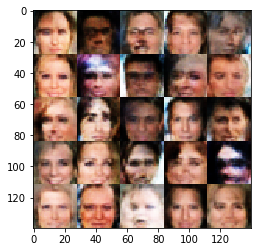

Epoch 1/1 - Batch 2710/6331:  Discriminator loss = 0.8078  Generator loss = 1.9949
Epoch 1/1 - Batch 2720/6331:  Discriminator loss = 0.9506  Generator loss = 0.9997
Epoch 1/1 - Batch 2730/6331:  Discriminator loss = 0.9966  Generator loss = 2.3766
Epoch 1/1 - Batch 2740/6331:  Discriminator loss = 1.1769  Generator loss = 0.7548
Epoch 1/1 - Batch 2750/6331:  Discriminator loss = 0.9247  Generator loss = 1.7749
Epoch 1/1 - Batch 2760/6331:  Discriminator loss = 0.7694  Generator loss = 1.3957
Epoch 1/1 - Batch 2770/6331:  Discriminator loss = 0.8170  Generator loss = 1.0985
Epoch 1/1 - Batch 2780/6331:  Discriminator loss = 1.0640  Generator loss = 0.8938
Epoch 1/1 - Batch 2790/6331:  Discriminator loss = 0.7705  Generator loss = 1.3919
Epoch 1/1 - Batch 2800/6331:  Discriminator loss = 0.7067  Generator loss = 1.7083


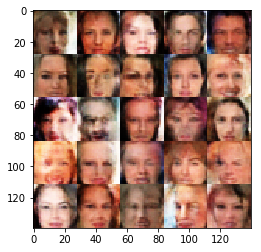

Epoch 1/1 - Batch 2810/6331:  Discriminator loss = 1.0394  Generator loss = 0.7891
Epoch 1/1 - Batch 2820/6331:  Discriminator loss = 0.7909  Generator loss = 1.4201
Epoch 1/1 - Batch 2830/6331:  Discriminator loss = 0.9730  Generator loss = 2.1480
Epoch 1/1 - Batch 2840/6331:  Discriminator loss = 0.7166  Generator loss = 1.2740
Epoch 1/1 - Batch 2850/6331:  Discriminator loss = 0.8515  Generator loss = 1.4670
Epoch 1/1 - Batch 2860/6331:  Discriminator loss = 1.5301  Generator loss = 0.5126
Epoch 1/1 - Batch 2870/6331:  Discriminator loss = 0.8336  Generator loss = 1.5497
Epoch 1/1 - Batch 2880/6331:  Discriminator loss = 1.4287  Generator loss = 0.4821
Epoch 1/1 - Batch 2890/6331:  Discriminator loss = 1.3857  Generator loss = 0.5508
Epoch 1/1 - Batch 2900/6331:  Discriminator loss = 0.9189  Generator loss = 1.3793


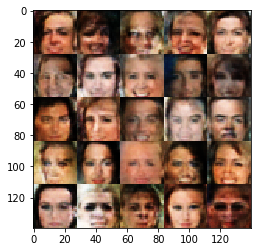

Epoch 1/1 - Batch 2910/6331:  Discriminator loss = 0.7637  Generator loss = 1.4543
Epoch 1/1 - Batch 2920/6331:  Discriminator loss = 1.1220  Generator loss = 0.7949
Epoch 1/1 - Batch 2930/6331:  Discriminator loss = 0.6981  Generator loss = 2.0885
Epoch 1/1 - Batch 2940/6331:  Discriminator loss = 0.9970  Generator loss = 1.3232
Epoch 1/1 - Batch 2950/6331:  Discriminator loss = 1.0244  Generator loss = 0.9250
Epoch 1/1 - Batch 2960/6331:  Discriminator loss = 1.5268  Generator loss = 0.4479
Epoch 1/1 - Batch 2970/6331:  Discriminator loss = 1.2118  Generator loss = 0.6466
Epoch 1/1 - Batch 2980/6331:  Discriminator loss = 0.7667  Generator loss = 1.2837
Epoch 1/1 - Batch 2990/6331:  Discriminator loss = 1.3522  Generator loss = 0.4773
Epoch 1/1 - Batch 3000/6331:  Discriminator loss = 1.9209  Generator loss = 0.2707


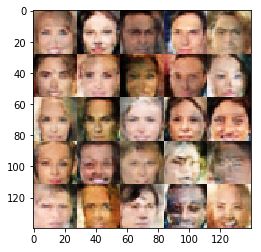

Epoch 1/1 - Batch 3010/6331:  Discriminator loss = 0.6775  Generator loss = 1.6143
Epoch 1/1 - Batch 3020/6331:  Discriminator loss = 0.8977  Generator loss = 1.0980
Epoch 1/1 - Batch 3030/6331:  Discriminator loss = 1.2959  Generator loss = 0.5611
Epoch 1/1 - Batch 3040/6331:  Discriminator loss = 1.1629  Generator loss = 2.3922
Epoch 1/1 - Batch 3050/6331:  Discriminator loss = 0.7935  Generator loss = 1.3764
Epoch 1/1 - Batch 3060/6331:  Discriminator loss = 0.7140  Generator loss = 1.5460
Epoch 1/1 - Batch 3070/6331:  Discriminator loss = 1.0398  Generator loss = 0.7935
Epoch 1/1 - Batch 3080/6331:  Discriminator loss = 0.6333  Generator loss = 1.7136
Epoch 1/1 - Batch 3090/6331:  Discriminator loss = 0.9563  Generator loss = 0.8963
Epoch 1/1 - Batch 3100/6331:  Discriminator loss = 0.9164  Generator loss = 1.1425


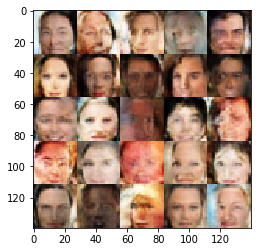

Epoch 1/1 - Batch 3110/6331:  Discriminator loss = 1.1421  Generator loss = 0.7099
Epoch 1/1 - Batch 3120/6331:  Discriminator loss = 1.6328  Generator loss = 0.4564
Epoch 1/1 - Batch 3130/6331:  Discriminator loss = 0.9837  Generator loss = 1.4882
Epoch 1/1 - Batch 3140/6331:  Discriminator loss = 1.2003  Generator loss = 0.6329
Epoch 1/1 - Batch 3150/6331:  Discriminator loss = 0.6587  Generator loss = 1.9151
Epoch 1/1 - Batch 3160/6331:  Discriminator loss = 0.9758  Generator loss = 1.1338
Epoch 1/1 - Batch 3170/6331:  Discriminator loss = 1.0415  Generator loss = 0.8467
Epoch 1/1 - Batch 3180/6331:  Discriminator loss = 0.7938  Generator loss = 1.5962
Epoch 1/1 - Batch 3190/6331:  Discriminator loss = 0.7368  Generator loss = 1.4822
Epoch 1/1 - Batch 3200/6331:  Discriminator loss = 0.6403  Generator loss = 2.1514


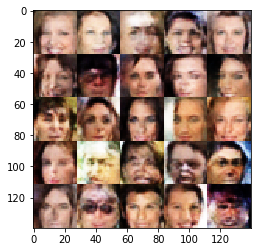

Epoch 1/1 - Batch 3210/6331:  Discriminator loss = 0.9860  Generator loss = 0.8933
Epoch 1/1 - Batch 3220/6331:  Discriminator loss = 0.9611  Generator loss = 0.9339
Epoch 1/1 - Batch 3230/6331:  Discriminator loss = 0.8308  Generator loss = 1.1727
Epoch 1/1 - Batch 3240/6331:  Discriminator loss = 0.8695  Generator loss = 1.4553
Epoch 1/1 - Batch 3250/6331:  Discriminator loss = 0.9253  Generator loss = 1.0457
Epoch 1/1 - Batch 3260/6331:  Discriminator loss = 0.7782  Generator loss = 1.2013
Epoch 1/1 - Batch 3270/6331:  Discriminator loss = 0.6950  Generator loss = 1.4868
Epoch 1/1 - Batch 3280/6331:  Discriminator loss = 0.8037  Generator loss = 1.1848
Epoch 1/1 - Batch 3290/6331:  Discriminator loss = 0.5936  Generator loss = 2.0152
Epoch 1/1 - Batch 3300/6331:  Discriminator loss = 1.5958  Generator loss = 0.4753


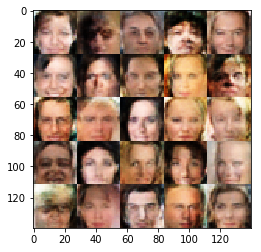

Epoch 1/1 - Batch 3310/6331:  Discriminator loss = 0.7945  Generator loss = 2.4798
Epoch 1/1 - Batch 3320/6331:  Discriminator loss = 0.7171  Generator loss = 2.3988
Epoch 1/1 - Batch 3330/6331:  Discriminator loss = 0.6338  Generator loss = 1.7364
Epoch 1/1 - Batch 3340/6331:  Discriminator loss = 0.6597  Generator loss = 2.0669
Epoch 1/1 - Batch 3350/6331:  Discriminator loss = 0.7245  Generator loss = 1.5869
Epoch 1/1 - Batch 3360/6331:  Discriminator loss = 0.6574  Generator loss = 1.6414
Epoch 1/1 - Batch 3370/6331:  Discriminator loss = 0.6918  Generator loss = 1.5770
Epoch 1/1 - Batch 3380/6331:  Discriminator loss = 1.4826  Generator loss = 0.4632
Epoch 1/1 - Batch 3390/6331:  Discriminator loss = 0.7308  Generator loss = 1.5033
Epoch 1/1 - Batch 3400/6331:  Discriminator loss = 0.6892  Generator loss = 1.8665


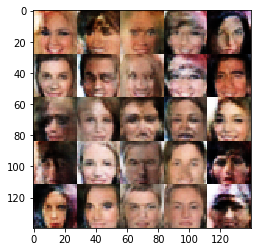

Epoch 1/1 - Batch 3410/6331:  Discriminator loss = 0.9022  Generator loss = 2.2571
Epoch 1/1 - Batch 3420/6331:  Discriminator loss = 0.7965  Generator loss = 1.1950
Epoch 1/1 - Batch 3430/6331:  Discriminator loss = 0.8018  Generator loss = 1.1864
Epoch 1/1 - Batch 3440/6331:  Discriminator loss = 0.6919  Generator loss = 1.4664
Epoch 1/1 - Batch 3450/6331:  Discriminator loss = 0.7152  Generator loss = 1.2928
Epoch 1/1 - Batch 3460/6331:  Discriminator loss = 0.7851  Generator loss = 1.2523
Epoch 1/1 - Batch 3470/6331:  Discriminator loss = 1.0755  Generator loss = 0.7991
Epoch 1/1 - Batch 3480/6331:  Discriminator loss = 0.5802  Generator loss = 2.2570
Epoch 1/1 - Batch 3490/6331:  Discriminator loss = 1.5561  Generator loss = 0.4364
Epoch 1/1 - Batch 3500/6331:  Discriminator loss = 0.7066  Generator loss = 1.5863


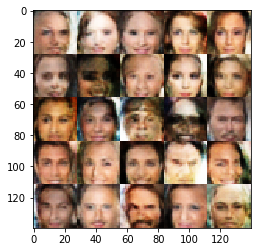

Epoch 1/1 - Batch 3510/6331:  Discriminator loss = 0.9988  Generator loss = 0.9031
Epoch 1/1 - Batch 3520/6331:  Discriminator loss = 1.8152  Generator loss = 3.4613
Epoch 1/1 - Batch 3530/6331:  Discriminator loss = 0.7369  Generator loss = 1.3707
Epoch 1/1 - Batch 3540/6331:  Discriminator loss = 1.4915  Generator loss = 0.4609
Epoch 1/1 - Batch 3550/6331:  Discriminator loss = 1.2837  Generator loss = 0.5253
Epoch 1/1 - Batch 3560/6331:  Discriminator loss = 0.6396  Generator loss = 2.0446
Epoch 1/1 - Batch 3570/6331:  Discriminator loss = 0.7599  Generator loss = 1.3905
Epoch 1/1 - Batch 3580/6331:  Discriminator loss = 0.8959  Generator loss = 2.5784
Epoch 1/1 - Batch 3590/6331:  Discriminator loss = 0.9946  Generator loss = 0.9149
Epoch 1/1 - Batch 3600/6331:  Discriminator loss = 0.8141  Generator loss = 1.1139


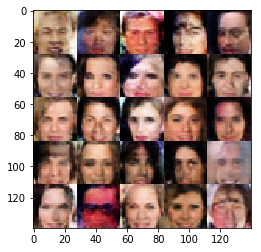

Epoch 1/1 - Batch 3610/6331:  Discriminator loss = 1.1701  Generator loss = 0.6482
Epoch 1/1 - Batch 3620/6331:  Discriminator loss = 0.6292  Generator loss = 1.6238
Epoch 1/1 - Batch 3630/6331:  Discriminator loss = 1.0741  Generator loss = 0.7375
Epoch 1/1 - Batch 3640/6331:  Discriminator loss = 0.5583  Generator loss = 2.3105
Epoch 1/1 - Batch 3650/6331:  Discriminator loss = 0.7183  Generator loss = 1.5440
Epoch 1/1 - Batch 3660/6331:  Discriminator loss = 0.5946  Generator loss = 1.9378
Epoch 1/1 - Batch 3670/6331:  Discriminator loss = 0.6007  Generator loss = 1.7922
Epoch 1/1 - Batch 3680/6331:  Discriminator loss = 0.4947  Generator loss = 2.2846
Epoch 1/1 - Batch 3690/6331:  Discriminator loss = 0.5654  Generator loss = 1.9106
Epoch 1/1 - Batch 3700/6331:  Discriminator loss = 0.6359  Generator loss = 1.8416


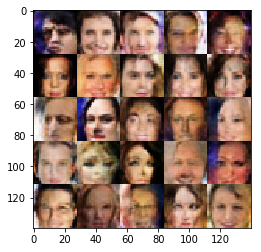

Epoch 1/1 - Batch 3710/6331:  Discriminator loss = 0.5964  Generator loss = 2.2306
Epoch 1/1 - Batch 3720/6331:  Discriminator loss = 0.7532  Generator loss = 2.1500
Epoch 1/1 - Batch 3730/6331:  Discriminator loss = 0.6992  Generator loss = 1.6753
Epoch 1/1 - Batch 3740/6331:  Discriminator loss = 0.9732  Generator loss = 1.0331
Epoch 1/1 - Batch 3750/6331:  Discriminator loss = 0.5438  Generator loss = 2.1946
Epoch 1/1 - Batch 3760/6331:  Discriminator loss = 0.7695  Generator loss = 1.3827
Epoch 1/1 - Batch 3770/6331:  Discriminator loss = 0.5017  Generator loss = 2.4205
Epoch 1/1 - Batch 3780/6331:  Discriminator loss = 0.5426  Generator loss = 1.9239
Epoch 1/1 - Batch 3790/6331:  Discriminator loss = 0.5322  Generator loss = 3.2265
Epoch 1/1 - Batch 3800/6331:  Discriminator loss = 0.7717  Generator loss = 1.3849


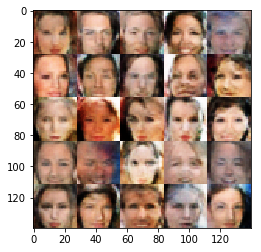

Epoch 1/1 - Batch 3810/6331:  Discriminator loss = 0.8090  Generator loss = 1.1386
Epoch 1/1 - Batch 3820/6331:  Discriminator loss = 0.8007  Generator loss = 1.1665
Epoch 1/1 - Batch 3830/6331:  Discriminator loss = 0.6535  Generator loss = 1.5322
Epoch 1/1 - Batch 3840/6331:  Discriminator loss = 1.0203  Generator loss = 0.8342
Epoch 1/1 - Batch 3850/6331:  Discriminator loss = 0.7575  Generator loss = 1.3098
Epoch 1/1 - Batch 3860/6331:  Discriminator loss = 0.6264  Generator loss = 1.6739
Epoch 1/1 - Batch 3870/6331:  Discriminator loss = 1.0932  Generator loss = 3.3204
Epoch 1/1 - Batch 3880/6331:  Discriminator loss = 0.8666  Generator loss = 1.0808
Epoch 1/1 - Batch 3890/6331:  Discriminator loss = 0.5776  Generator loss = 2.0636
Epoch 1/1 - Batch 3900/6331:  Discriminator loss = 0.9648  Generator loss = 1.0496


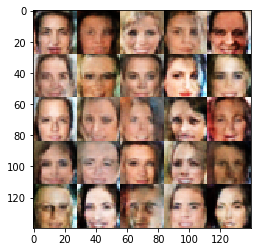

Epoch 1/1 - Batch 3910/6331:  Discriminator loss = 0.6011  Generator loss = 1.9973
Epoch 1/1 - Batch 3920/6331:  Discriminator loss = 0.7347  Generator loss = 1.3322
Epoch 1/1 - Batch 3930/6331:  Discriminator loss = 0.8960  Generator loss = 1.0182
Epoch 1/1 - Batch 3940/6331:  Discriminator loss = 0.5308  Generator loss = 2.1205
Epoch 1/1 - Batch 3950/6331:  Discriminator loss = 1.6698  Generator loss = 0.3636
Epoch 1/1 - Batch 3960/6331:  Discriminator loss = 0.7414  Generator loss = 2.0799
Epoch 1/1 - Batch 3970/6331:  Discriminator loss = 0.8775  Generator loss = 1.7010
Epoch 1/1 - Batch 3980/6331:  Discriminator loss = 0.9418  Generator loss = 2.6381
Epoch 1/1 - Batch 3990/6331:  Discriminator loss = 0.8959  Generator loss = 1.0641
Epoch 1/1 - Batch 4000/6331:  Discriminator loss = 1.1198  Generator loss = 1.7846


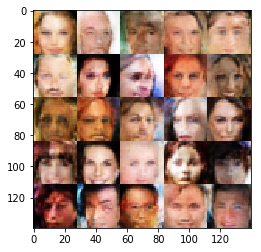

Epoch 1/1 - Batch 4010/6331:  Discriminator loss = 0.7042  Generator loss = 1.4218
Epoch 1/1 - Batch 4020/6331:  Discriminator loss = 0.6580  Generator loss = 1.4701
Epoch 1/1 - Batch 4030/6331:  Discriminator loss = 0.7641  Generator loss = 1.2043
Epoch 1/1 - Batch 4040/6331:  Discriminator loss = 0.9105  Generator loss = 0.9891
Epoch 1/1 - Batch 4050/6331:  Discriminator loss = 0.6696  Generator loss = 1.6412
Epoch 1/1 - Batch 4060/6331:  Discriminator loss = 0.6327  Generator loss = 1.5748
Epoch 1/1 - Batch 4070/6331:  Discriminator loss = 0.8251  Generator loss = 1.1160
Epoch 1/1 - Batch 4080/6331:  Discriminator loss = 0.6849  Generator loss = 1.5475
Epoch 1/1 - Batch 4090/6331:  Discriminator loss = 0.7217  Generator loss = 2.1825
Epoch 1/1 - Batch 4100/6331:  Discriminator loss = 0.5394  Generator loss = 2.3557


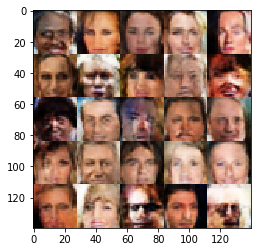

Epoch 1/1 - Batch 4110/6331:  Discriminator loss = 0.7775  Generator loss = 1.1929
Epoch 1/1 - Batch 4120/6331:  Discriminator loss = 0.5181  Generator loss = 2.1868
Epoch 1/1 - Batch 4130/6331:  Discriminator loss = 0.5715  Generator loss = 2.2376
Epoch 1/1 - Batch 4140/6331:  Discriminator loss = 0.5462  Generator loss = 2.1984
Epoch 1/1 - Batch 4150/6331:  Discriminator loss = 0.7794  Generator loss = 1.4306
Epoch 1/1 - Batch 4160/6331:  Discriminator loss = 1.6558  Generator loss = 4.2897
Epoch 1/1 - Batch 4170/6331:  Discriminator loss = 0.9476  Generator loss = 1.1158
Epoch 1/1 - Batch 4180/6331:  Discriminator loss = 0.6113  Generator loss = 2.0588
Epoch 1/1 - Batch 4190/6331:  Discriminator loss = 0.6607  Generator loss = 2.3172
Epoch 1/1 - Batch 4200/6331:  Discriminator loss = 0.6607  Generator loss = 1.4624


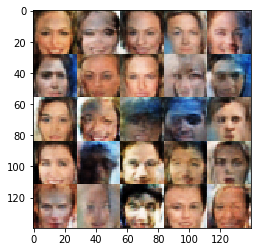

Epoch 1/1 - Batch 4210/6331:  Discriminator loss = 0.6564  Generator loss = 1.4169
Epoch 1/1 - Batch 4220/6331:  Discriminator loss = 0.4812  Generator loss = 2.2320
Epoch 1/1 - Batch 4230/6331:  Discriminator loss = 0.7308  Generator loss = 1.3100
Epoch 1/1 - Batch 4240/6331:  Discriminator loss = 0.4589  Generator loss = 2.8213
Epoch 1/1 - Batch 4250/6331:  Discriminator loss = 0.4600  Generator loss = 2.6403
Epoch 1/1 - Batch 4260/6331:  Discriminator loss = 0.4517  Generator loss = 2.5874
Epoch 1/1 - Batch 4270/6331:  Discriminator loss = 0.4370  Generator loss = 2.9624
Epoch 1/1 - Batch 4280/6331:  Discriminator loss = 0.6081  Generator loss = 1.6872
Epoch 1/1 - Batch 4290/6331:  Discriminator loss = 1.5546  Generator loss = 2.6811
Epoch 1/1 - Batch 4300/6331:  Discriminator loss = 0.7661  Generator loss = 1.5036


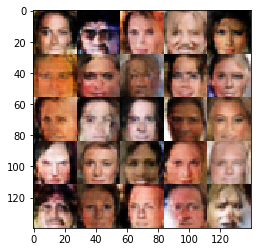

Epoch 1/1 - Batch 4310/6331:  Discriminator loss = 0.6307  Generator loss = 1.8511
Epoch 1/1 - Batch 4320/6331:  Discriminator loss = 0.8891  Generator loss = 2.5959
Epoch 1/1 - Batch 4330/6331:  Discriminator loss = 0.5847  Generator loss = 2.2462
Epoch 1/1 - Batch 4340/6331:  Discriminator loss = 0.6708  Generator loss = 1.4977
Epoch 1/1 - Batch 4350/6331:  Discriminator loss = 1.0392  Generator loss = 1.9824
Epoch 1/1 - Batch 4360/6331:  Discriminator loss = 1.0259  Generator loss = 0.9123
Epoch 1/1 - Batch 4370/6331:  Discriminator loss = 0.4439  Generator loss = 2.6121
Epoch 1/1 - Batch 4380/6331:  Discriminator loss = 1.1681  Generator loss = 0.7248
Epoch 1/1 - Batch 4390/6331:  Discriminator loss = 0.5875  Generator loss = 3.5881
Epoch 1/1 - Batch 4400/6331:  Discriminator loss = 0.5577  Generator loss = 2.4649


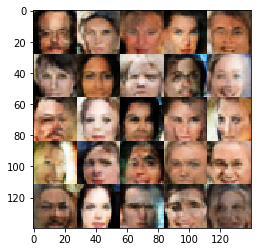

Epoch 1/1 - Batch 4410/6331:  Discriminator loss = 0.5153  Generator loss = 2.2079
Epoch 1/1 - Batch 4420/6331:  Discriminator loss = 0.4310  Generator loss = 3.1356
Epoch 1/1 - Batch 4430/6331:  Discriminator loss = 0.5439  Generator loss = 1.9798
Epoch 1/1 - Batch 4440/6331:  Discriminator loss = 0.5804  Generator loss = 2.0485
Epoch 1/1 - Batch 4450/6331:  Discriminator loss = 0.5432  Generator loss = 2.2984
Epoch 1/1 - Batch 4460/6331:  Discriminator loss = 0.5509  Generator loss = 1.9080
Epoch 1/1 - Batch 4470/6331:  Discriminator loss = 0.4245  Generator loss = 3.3446
Epoch 1/1 - Batch 4480/6331:  Discriminator loss = 0.6444  Generator loss = 1.9854
Epoch 1/1 - Batch 4490/6331:  Discriminator loss = 0.6879  Generator loss = 1.3767
Epoch 1/1 - Batch 4500/6331:  Discriminator loss = 1.3384  Generator loss = 0.5705


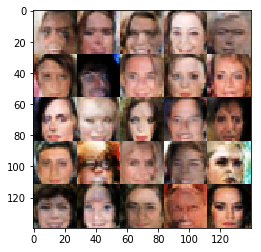

Epoch 1/1 - Batch 4510/6331:  Discriminator loss = 0.4750  Generator loss = 2.7295
Epoch 1/1 - Batch 4520/6331:  Discriminator loss = 0.5159  Generator loss = 2.4698
Epoch 1/1 - Batch 4530/6331:  Discriminator loss = 0.4229  Generator loss = 2.9777
Epoch 1/1 - Batch 4540/6331:  Discriminator loss = 0.5109  Generator loss = 2.1786
Epoch 1/1 - Batch 4550/6331:  Discriminator loss = 0.5865  Generator loss = 1.8732
Epoch 1/1 - Batch 4560/6331:  Discriminator loss = 0.3852  Generator loss = 4.2600
Epoch 1/1 - Batch 4570/6331:  Discriminator loss = 0.6319  Generator loss = 1.6092
Epoch 1/1 - Batch 4580/6331:  Discriminator loss = 1.4677  Generator loss = 0.5582
Epoch 1/1 - Batch 4590/6331:  Discriminator loss = 1.1781  Generator loss = 0.7336
Epoch 1/1 - Batch 4600/6331:  Discriminator loss = 0.4918  Generator loss = 2.3527


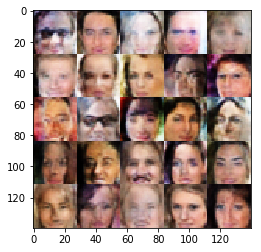

Epoch 1/1 - Batch 4610/6331:  Discriminator loss = 0.5113  Generator loss = 2.7784
Epoch 1/1 - Batch 4620/6331:  Discriminator loss = 0.5822  Generator loss = 1.7838
Epoch 1/1 - Batch 4630/6331:  Discriminator loss = 0.3832  Generator loss = 3.4930
Epoch 1/1 - Batch 4640/6331:  Discriminator loss = 0.5040  Generator loss = 2.2406
Epoch 1/1 - Batch 4650/6331:  Discriminator loss = 0.4097  Generator loss = 3.2007
Epoch 1/1 - Batch 4660/6331:  Discriminator loss = 0.4330  Generator loss = 2.8670
Epoch 1/1 - Batch 4670/6331:  Discriminator loss = 0.5621  Generator loss = 1.8477
Epoch 1/1 - Batch 4680/6331:  Discriminator loss = 0.5158  Generator loss = 2.0292
Epoch 1/1 - Batch 4690/6331:  Discriminator loss = 0.4686  Generator loss = 2.5882
Epoch 1/1 - Batch 4700/6331:  Discriminator loss = 0.5086  Generator loss = 2.1366


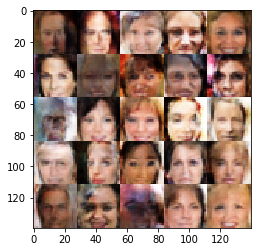

Epoch 1/1 - Batch 4710/6331:  Discriminator loss = 0.5622  Generator loss = 2.0634
Epoch 1/1 - Batch 4720/6331:  Discriminator loss = 0.5896  Generator loss = 1.8736
Epoch 1/1 - Batch 4730/6331:  Discriminator loss = 0.4945  Generator loss = 2.2486
Epoch 1/1 - Batch 4740/6331:  Discriminator loss = 0.9744  Generator loss = 1.0137
Epoch 1/1 - Batch 4750/6331:  Discriminator loss = 0.4347  Generator loss = 2.8175
Epoch 1/1 - Batch 4760/6331:  Discriminator loss = 0.4220  Generator loss = 2.8146
Epoch 1/1 - Batch 4770/6331:  Discriminator loss = 0.5493  Generator loss = 1.8987
Epoch 1/1 - Batch 4780/6331:  Discriminator loss = 0.5786  Generator loss = 1.7806
Epoch 1/1 - Batch 4790/6331:  Discriminator loss = 0.6253  Generator loss = 1.6161
Epoch 1/1 - Batch 4800/6331:  Discriminator loss = 0.3823  Generator loss = 4.6369


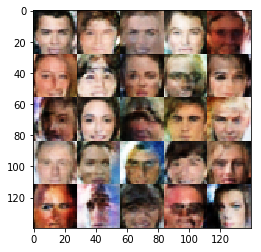

Epoch 1/1 - Batch 4810/6331:  Discriminator loss = 0.4400  Generator loss = 3.1450
Epoch 1/1 - Batch 4820/6331:  Discriminator loss = 1.0409  Generator loss = 5.5262
Epoch 1/1 - Batch 4830/6331:  Discriminator loss = 2.6131  Generator loss = 0.1866
Epoch 1/1 - Batch 4840/6331:  Discriminator loss = 0.6224  Generator loss = 1.8145
Epoch 1/1 - Batch 4850/6331:  Discriminator loss = 0.8637  Generator loss = 1.1597
Epoch 1/1 - Batch 4860/6331:  Discriminator loss = 0.5855  Generator loss = 2.1878
Epoch 1/1 - Batch 4870/6331:  Discriminator loss = 0.4407  Generator loss = 2.6580
Epoch 1/1 - Batch 4880/6331:  Discriminator loss = 0.5317  Generator loss = 1.9565
Epoch 1/1 - Batch 4890/6331:  Discriminator loss = 0.4290  Generator loss = 2.9281
Epoch 1/1 - Batch 4900/6331:  Discriminator loss = 0.5306  Generator loss = 2.0646


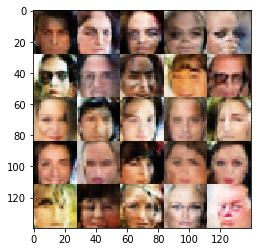

Epoch 1/1 - Batch 4910/6331:  Discriminator loss = 0.5058  Generator loss = 2.4217
Epoch 1/1 - Batch 4920/6331:  Discriminator loss = 0.4794  Generator loss = 2.3637
Epoch 1/1 - Batch 4930/6331:  Discriminator loss = 0.7283  Generator loss = 1.3928
Epoch 1/1 - Batch 4940/6331:  Discriminator loss = 0.5367  Generator loss = 2.1665
Epoch 1/1 - Batch 4950/6331:  Discriminator loss = 0.6174  Generator loss = 1.7619
Epoch 1/1 - Batch 4960/6331:  Discriminator loss = 0.6978  Generator loss = 1.4307
Epoch 1/1 - Batch 4970/6331:  Discriminator loss = 0.4655  Generator loss = 2.9780
Epoch 1/1 - Batch 4980/6331:  Discriminator loss = 0.6499  Generator loss = 3.1085
Epoch 1/1 - Batch 4990/6331:  Discriminator loss = 0.7943  Generator loss = 1.2924
Epoch 1/1 - Batch 5000/6331:  Discriminator loss = 2.8226  Generator loss = 0.1742


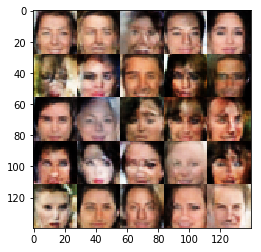

Epoch 1/1 - Batch 5010/6331:  Discriminator loss = 1.2084  Generator loss = 0.6655
Epoch 1/1 - Batch 5020/6331:  Discriminator loss = 0.5968  Generator loss = 1.8542
Epoch 1/1 - Batch 5030/6331:  Discriminator loss = 1.2686  Generator loss = 0.6598
Epoch 1/1 - Batch 5040/6331:  Discriminator loss = 0.4291  Generator loss = 2.9960
Epoch 1/1 - Batch 5050/6331:  Discriminator loss = 0.6657  Generator loss = 1.4129
Epoch 1/1 - Batch 5060/6331:  Discriminator loss = 0.6668  Generator loss = 1.5986
Epoch 1/1 - Batch 5070/6331:  Discriminator loss = 0.4981  Generator loss = 2.1899
Epoch 1/1 - Batch 5080/6331:  Discriminator loss = 0.4125  Generator loss = 2.9538
Epoch 1/1 - Batch 5090/6331:  Discriminator loss = 0.5171  Generator loss = 2.1159
Epoch 1/1 - Batch 5100/6331:  Discriminator loss = 0.5003  Generator loss = 2.2630


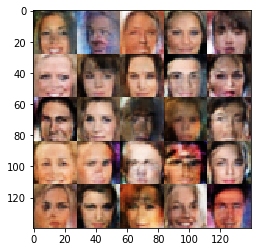

Epoch 1/1 - Batch 5110/6331:  Discriminator loss = 0.4665  Generator loss = 2.6431
Epoch 1/1 - Batch 5120/6331:  Discriminator loss = 0.6655  Generator loss = 1.5342
Epoch 1/1 - Batch 5130/6331:  Discriminator loss = 0.8759  Generator loss = 1.1872
Epoch 1/1 - Batch 5140/6331:  Discriminator loss = 0.6157  Generator loss = 1.7263
Epoch 1/1 - Batch 5150/6331:  Discriminator loss = 0.4939  Generator loss = 2.3072
Epoch 1/1 - Batch 5160/6331:  Discriminator loss = 0.5781  Generator loss = 1.7021
Epoch 1/1 - Batch 5170/6331:  Discriminator loss = 0.4706  Generator loss = 3.4920
Epoch 1/1 - Batch 5180/6331:  Discriminator loss = 0.5278  Generator loss = 2.3067
Epoch 1/1 - Batch 5190/6331:  Discriminator loss = 0.7440  Generator loss = 1.2729
Epoch 1/1 - Batch 5200/6331:  Discriminator loss = 0.5179  Generator loss = 2.1325


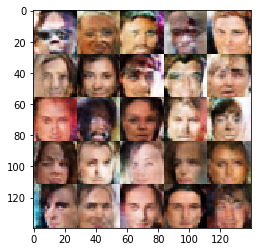

Epoch 1/1 - Batch 5210/6331:  Discriminator loss = 0.4379  Generator loss = 3.5224
Epoch 1/1 - Batch 5220/6331:  Discriminator loss = 1.5632  Generator loss = 3.4185
Epoch 1/1 - Batch 5230/6331:  Discriminator loss = 0.6850  Generator loss = 1.8275
Epoch 1/1 - Batch 5240/6331:  Discriminator loss = 0.6187  Generator loss = 2.0117
Epoch 1/1 - Batch 5250/6331:  Discriminator loss = 0.9795  Generator loss = 1.6997
Epoch 1/1 - Batch 5260/6331:  Discriminator loss = 0.5127  Generator loss = 2.2985
Epoch 1/1 - Batch 5270/6331:  Discriminator loss = 0.4013  Generator loss = 3.3880
Epoch 1/1 - Batch 5280/6331:  Discriminator loss = 0.4853  Generator loss = 2.3164
Epoch 1/1 - Batch 5290/6331:  Discriminator loss = 0.4416  Generator loss = 2.6417
Epoch 1/1 - Batch 5300/6331:  Discriminator loss = 0.4472  Generator loss = 3.3246


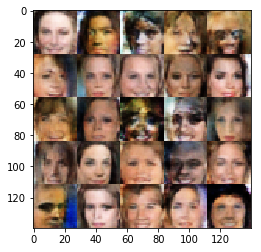

Epoch 1/1 - Batch 5310/6331:  Discriminator loss = 0.4926  Generator loss = 4.1498
Epoch 1/1 - Batch 5320/6331:  Discriminator loss = 0.5655  Generator loss = 1.9082
Epoch 1/1 - Batch 5330/6331:  Discriminator loss = 0.6737  Generator loss = 1.5152
Epoch 1/1 - Batch 5340/6331:  Discriminator loss = 0.4455  Generator loss = 2.5479
Epoch 1/1 - Batch 5350/6331:  Discriminator loss = 0.4616  Generator loss = 2.4036
Epoch 1/1 - Batch 5360/6331:  Discriminator loss = 0.5051  Generator loss = 4.8844
Epoch 1/1 - Batch 5370/6331:  Discriminator loss = 0.4938  Generator loss = 2.3093
Epoch 1/1 - Batch 5380/6331:  Discriminator loss = 0.5033  Generator loss = 2.1260
Epoch 1/1 - Batch 5390/6331:  Discriminator loss = 0.5587  Generator loss = 3.9894
Epoch 1/1 - Batch 5400/6331:  Discriminator loss = 1.2774  Generator loss = 0.6566


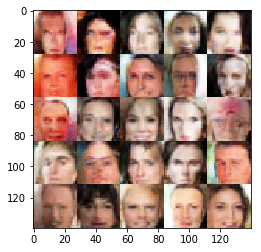

Epoch 1/1 - Batch 5410/6331:  Discriminator loss = 0.4044  Generator loss = 3.4852
Epoch 1/1 - Batch 5420/6331:  Discriminator loss = 0.4782  Generator loss = 2.9754
Epoch 1/1 - Batch 5430/6331:  Discriminator loss = 0.9185  Generator loss = 1.0327
Epoch 1/1 - Batch 5440/6331:  Discriminator loss = 0.6053  Generator loss = 2.6224
Epoch 1/1 - Batch 5450/6331:  Discriminator loss = 0.7058  Generator loss = 2.2537
Epoch 1/1 - Batch 5460/6331:  Discriminator loss = 0.7820  Generator loss = 1.4136
Epoch 1/1 - Batch 5470/6331:  Discriminator loss = 0.4991  Generator loss = 2.3952
Epoch 1/1 - Batch 5480/6331:  Discriminator loss = 0.4582  Generator loss = 2.8402
Epoch 1/1 - Batch 5490/6331:  Discriminator loss = 0.9138  Generator loss = 1.0038
Epoch 1/1 - Batch 5500/6331:  Discriminator loss = 0.5459  Generator loss = 2.0013


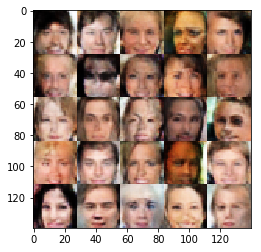

Epoch 1/1 - Batch 5510/6331:  Discriminator loss = 0.5046  Generator loss = 2.3226
Epoch 1/1 - Batch 5520/6331:  Discriminator loss = 0.6316  Generator loss = 1.6685
Epoch 1/1 - Batch 5530/6331:  Discriminator loss = 0.7028  Generator loss = 1.4374
Epoch 1/1 - Batch 5540/6331:  Discriminator loss = 0.4896  Generator loss = 2.2571
Epoch 1/1 - Batch 5550/6331:  Discriminator loss = 0.8782  Generator loss = 1.0873
Epoch 1/1 - Batch 5560/6331:  Discriminator loss = 0.4259  Generator loss = 3.1015
Epoch 1/1 - Batch 5570/6331:  Discriminator loss = 0.4982  Generator loss = 2.2708
Epoch 1/1 - Batch 5580/6331:  Discriminator loss = 0.3829  Generator loss = 3.5827
Epoch 1/1 - Batch 5590/6331:  Discriminator loss = 0.7517  Generator loss = 1.2622
Epoch 1/1 - Batch 5600/6331:  Discriminator loss = 0.8860  Generator loss = 1.0049


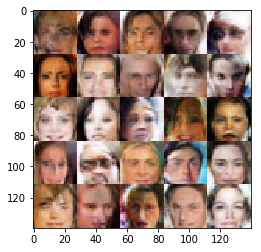

Epoch 1/1 - Batch 5610/6331:  Discriminator loss = 0.6098  Generator loss = 1.7063
Epoch 1/1 - Batch 5620/6331:  Discriminator loss = 0.6009  Generator loss = 4.3124
Epoch 1/1 - Batch 5630/6331:  Discriminator loss = 0.6005  Generator loss = 2.1471
Epoch 1/1 - Batch 5640/6331:  Discriminator loss = 0.7387  Generator loss = 1.4679
Epoch 1/1 - Batch 5650/6331:  Discriminator loss = 0.5026  Generator loss = 3.1898
Epoch 1/1 - Batch 5660/6331:  Discriminator loss = 0.5701  Generator loss = 2.0077
Epoch 1/1 - Batch 5670/6331:  Discriminator loss = 0.8089  Generator loss = 1.4134
Epoch 1/1 - Batch 5680/6331:  Discriminator loss = 0.7880  Generator loss = 3.7250
Epoch 1/1 - Batch 5690/6331:  Discriminator loss = 0.5178  Generator loss = 2.4973
Epoch 1/1 - Batch 5700/6331:  Discriminator loss = 0.5355  Generator loss = 2.3636


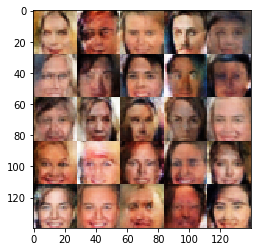

Epoch 1/1 - Batch 5710/6331:  Discriminator loss = 0.6644  Generator loss = 2.6682
Epoch 1/1 - Batch 5720/6331:  Discriminator loss = 0.9581  Generator loss = 1.0438
Epoch 1/1 - Batch 5730/6331:  Discriminator loss = 0.6476  Generator loss = 1.6717
Epoch 1/1 - Batch 5740/6331:  Discriminator loss = 0.4514  Generator loss = 2.5640
Epoch 1/1 - Batch 5750/6331:  Discriminator loss = 0.5329  Generator loss = 2.0997
Epoch 1/1 - Batch 5760/6331:  Discriminator loss = 0.4105  Generator loss = 3.4381
Epoch 1/1 - Batch 5770/6331:  Discriminator loss = 0.5316  Generator loss = 2.0134
Epoch 1/1 - Batch 5780/6331:  Discriminator loss = 0.6146  Generator loss = 1.6650
Epoch 1/1 - Batch 5790/6331:  Discriminator loss = 0.4090  Generator loss = 3.2971
Epoch 1/1 - Batch 5800/6331:  Discriminator loss = 0.4244  Generator loss = 3.0826


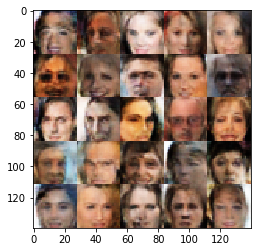

Epoch 1/1 - Batch 5810/6331:  Discriminator loss = 0.3755  Generator loss = 4.1862
Epoch 1/1 - Batch 5820/6331:  Discriminator loss = 0.4426  Generator loss = 3.0533
Epoch 1/1 - Batch 5830/6331:  Discriminator loss = 0.4689  Generator loss = 2.4523
Epoch 1/1 - Batch 5840/6331:  Discriminator loss = 0.9369  Generator loss = 0.9915
Epoch 1/1 - Batch 5850/6331:  Discriminator loss = 0.5809  Generator loss = 2.0693
Epoch 1/1 - Batch 5860/6331:  Discriminator loss = 0.5182  Generator loss = 2.6217
Epoch 1/1 - Batch 5870/6331:  Discriminator loss = 0.4776  Generator loss = 3.5609
Epoch 1/1 - Batch 5880/6331:  Discriminator loss = 0.4162  Generator loss = 3.3286
Epoch 1/1 - Batch 5890/6331:  Discriminator loss = 1.7076  Generator loss = 0.3784
Epoch 1/1 - Batch 5900/6331:  Discriminator loss = 0.9205  Generator loss = 0.9930


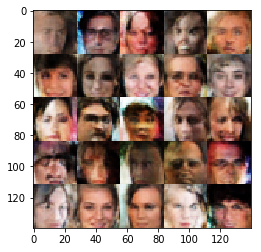

Epoch 1/1 - Batch 5910/6331:  Discriminator loss = 0.7594  Generator loss = 1.3009
Epoch 1/1 - Batch 5920/6331:  Discriminator loss = 0.6814  Generator loss = 1.4670
Epoch 1/1 - Batch 5930/6331:  Discriminator loss = 0.6999  Generator loss = 3.7654
Epoch 1/1 - Batch 5940/6331:  Discriminator loss = 0.6217  Generator loss = 1.6679
Epoch 1/1 - Batch 5950/6331:  Discriminator loss = 0.5646  Generator loss = 2.0159
Epoch 1/1 - Batch 5960/6331:  Discriminator loss = 0.5133  Generator loss = 2.1640
Epoch 1/1 - Batch 5970/6331:  Discriminator loss = 0.5797  Generator loss = 1.9128
Epoch 1/1 - Batch 5980/6331:  Discriminator loss = 0.6394  Generator loss = 1.5848
Epoch 1/1 - Batch 5990/6331:  Discriminator loss = 0.5029  Generator loss = 2.1400
Epoch 1/1 - Batch 6000/6331:  Discriminator loss = 0.4964  Generator loss = 2.3407


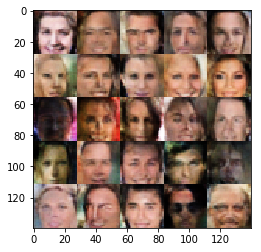

Epoch 1/1 - Batch 6010/6331:  Discriminator loss = 0.4604  Generator loss = 3.1411
Epoch 1/1 - Batch 6020/6331:  Discriminator loss = 0.4697  Generator loss = 2.4997
Epoch 1/1 - Batch 6030/6331:  Discriminator loss = 0.6144  Generator loss = 1.8114
Epoch 1/1 - Batch 6040/6331:  Discriminator loss = 1.4286  Generator loss = 4.8443
Epoch 1/1 - Batch 6050/6331:  Discriminator loss = 2.7925  Generator loss = 0.2061
Epoch 1/1 - Batch 6060/6331:  Discriminator loss = 0.6566  Generator loss = 1.8943
Epoch 1/1 - Batch 6070/6331:  Discriminator loss = 0.5948  Generator loss = 2.3893
Epoch 1/1 - Batch 6080/6331:  Discriminator loss = 0.5844  Generator loss = 2.1141
Epoch 1/1 - Batch 6090/6331:  Discriminator loss = 0.5499  Generator loss = 1.9239
Epoch 1/1 - Batch 6100/6331:  Discriminator loss = 0.6145  Generator loss = 1.8001


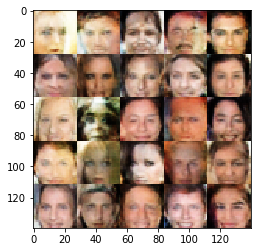

Epoch 1/1 - Batch 6110/6331:  Discriminator loss = 0.4211  Generator loss = 3.3489
Epoch 1/1 - Batch 6120/6331:  Discriminator loss = 0.7508  Generator loss = 1.7119
Epoch 1/1 - Batch 6130/6331:  Discriminator loss = 0.8039  Generator loss = 2.6073
Epoch 1/1 - Batch 6140/6331:  Discriminator loss = 0.6551  Generator loss = 2.8431
Epoch 1/1 - Batch 6150/6331:  Discriminator loss = 0.6849  Generator loss = 1.6141
Epoch 1/1 - Batch 6160/6331:  Discriminator loss = 0.3826  Generator loss = 3.6582
Epoch 1/1 - Batch 6170/6331:  Discriminator loss = 0.4195  Generator loss = 3.5918
Epoch 1/1 - Batch 6180/6331:  Discriminator loss = 0.6179  Generator loss = 1.8077
Epoch 1/1 - Batch 6190/6331:  Discriminator loss = 0.4472  Generator loss = 3.1203
Epoch 1/1 - Batch 6200/6331:  Discriminator loss = 0.4254  Generator loss = 3.3230


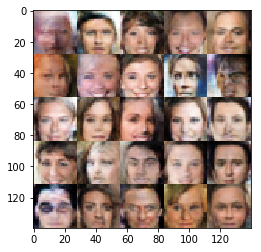

Epoch 1/1 - Batch 6210/6331:  Discriminator loss = 0.5984  Generator loss = 1.8015
Epoch 1/1 - Batch 6220/6331:  Discriminator loss = 0.6699  Generator loss = 1.6087
Epoch 1/1 - Batch 6230/6331:  Discriminator loss = 0.4569  Generator loss = 2.5064
Epoch 1/1 - Batch 6240/6331:  Discriminator loss = 0.4339  Generator loss = 2.9506
Epoch 1/1 - Batch 6250/6331:  Discriminator loss = 0.7876  Generator loss = 1.1606
Epoch 1/1 - Batch 6260/6331:  Discriminator loss = 1.0045  Generator loss = 0.9022
Epoch 1/1 - Batch 6270/6331:  Discriminator loss = 0.4320  Generator loss = 2.6909
Epoch 1/1 - Batch 6280/6331:  Discriminator loss = 0.4066  Generator loss = 3.0456
Epoch 1/1 - Batch 6290/6331:  Discriminator loss = 0.5298  Generator loss = 4.0852
Epoch 1/1 - Batch 6300/6331:  Discriminator loss = 0.5425  Generator loss = 1.9950


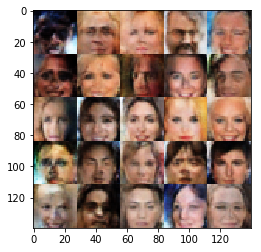

Epoch 1/1 - Batch 6310/6331:  Discriminator loss = 0.4825  Generator loss = 2.4624
Epoch 1/1 - Batch 6320/6331:  Discriminator loss = 0.6060  Generator loss = 1.8162
Epoch 1/1 - Batch 6330/6331:  Discriminator loss = 0.4757  Generator loss = 2.4361


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
n_images = 25


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)